In [1]:
import os

from dandi.dandiapi import DandiAPIClient
from dotenv import load_dotenv

# Load environment variables from .env file
# This is required at the moment because the data is on draft status
load_dotenv()
# Load token from environment variable
token = os.getenv("DANDI_API_TOKEN")
if not token:
    raise ValueError("DANDI_API_TOKEN environment variable not set. Please set it with your DANDI API token.")

dandiset_id = "001538"
client = DandiAPIClient(token=token)
client.authenticate(token=token)

dandiset = client.get_dandiset(dandiset_id, "draft")
assets = dandiset.get_assets()
assets_list = list(assets)

In [2]:
from typing import Literal

# Session ID Parsing Functions
# These functions decode the rich metadata encoded in DANDI file paths

def get_session_id(asset_path: str) -> str:
    """
    Extract session ID from DANDI asset path.
    
    DANDI encodes paths as:
    sub-<subject_id>/sub-<subject_id>_ses-<session_id>_[desc-<description>]_<modalities>.nwb
    
    Example path:
    'sub-SubjectRecordedAt20160523154318/sub-SubjectRecordedAt20160523154318_ses-F3++SomExc++iSPN++OffState++none++WT++20160523154318_icephys.nwb'
    
    The session_id contains experimental metadata separated by '++':
    F3++SomExc++iSPN++OffState++none++WT++20160523154318
    │   │       │     │        │     │   │
    │   │       │     │        │     │   └─ Timestamp
    │   │       │     │        │     └─ Genotype (WT=Wild Type)  
    │   │       │     │        └─ Pharmacology (none=no drugs)
    │   │       │     └─ State (OffState=no stimulation)
    │   │       └─ Cell Type (iSPN=indirect pathway spiny projection neuron)
    │   └─ Measurement (SomExc=somatic excitability)
    └─ Figure (F3=Figure 3)
    """
    if not asset_path:
        return ""
    bottom_level_path = asset_path.split("/")[1]  # Remove top level subject
    session_id_with_ses_prefix = bottom_level_path.split("_")[1]
    session_id = session_id_with_ses_prefix.split("-")[1]

    return session_id

# Metadata extraction functions - each extracts a specific experimental parameter

def get_figure_number(session_id: str):
    """Extract which figure this data corresponds to (F1, F2, F3, etc.)"""
    return session_id.split("++")[0]



def get_measurement(session_id: str) -> str:
    """
    Extract measurement type:
    - SomExc: Somatic excitability (patch clamp at cell body)
    - DendExc: Dendritic excitability (patch clamp + 2-photon imaging)
    - DendSpine: Dendritic spine density measurements
    - BehavAIMs: Abnormal involuntary movement behavioral scoring
    - StriAChFP: Striatal acetylcholine fluorescent protein imaging
    """
    if not session_id:
        return ""
    return session_id.split("++")[1]

def is_measurement(session_id: str, measurement: Literal["SomExc", "DendExc", "DendSpine", "DendConfSpine", "DendOEPSC", "StriAChFP", "BehavAIMs", "BehavRot", "BehavVideo", "AChFP", "AIMs", "ConfSpine", "SpineDens", "oEPSC", "video"]) -> bool:
    """Filter data by measurement/experiment type"""
    return get_measurement(session_id) == measurement

def get_cell_type(session_id: str) -> str:
    """
    Extract cell type:
    - dSPN: Direct pathway spiny projection neurons
    - iSPN: Indirect pathway spiny projection neurons  
    - pan: Pan-neuronal (both types)
    """
    if not session_id:
        return ""
    return session_id.split("++")[2]

def is_cell_type(session_id: str, cell_type: Literal["dSPN", "iSPN", "pan"]) -> bool:
    """Filter data by cell type"""
    return get_cell_type(session_id) == cell_type

def get_state(session_id: str) -> str:
    """
    Extract experimental state:
    - CTRL: Control condition
    - PD: Parkinson's disease model
    - OffState: No levodopa treatment
    - OnState: With levodopa treatment
    """
    if not session_id:
        return ""
    return session_id.split("++")[3]

def is_state(session_id: str, state: Literal["CTRL", "LesionedControl", "OFF", "ON", "OffState", "OnState", "PD"]) -> bool:
    """Filter data by disease/treatment state"""
    return get_state(session_id) == state

def get_pharmacology(session_id: str) -> str:
    """
    Extract pharmacological treatment:
    - none: No drugs applied
    - CNO: Clozapine N-oxide (DREADD activator)
    - D1RaSch: D1 receptor agonist SCH23390
    - M1RaOxoM: M1 receptor agonist Oxotremorine-M
    """
    if not session_id:
        return ""
    return session_id.split("++")[4]

def is_pharmacology(session_id: str, pharmacology: Literal["none", "WT", "DMSO", "CNO", "D1RaSch", "D2RaSul", "M1RaOxoM", "M1RaThp", "M1RaTri"]) -> bool:
    """Filter data by pharmacological condition"""
    return get_pharmacology(session_id) == pharmacology

def get_genotype(session_id: str) -> str:
    """
    Extract animal genotype:
    - WT: Wild type
    - M1RCRISPR: M1 receptor knockout
    - iSPNM1RKO: iSPN-specific M1 receptor knockout
    """
    if not session_id:
        return ""
    return session_id.split("++")[5]

def is_genotype(session_id: str, genotype: Literal["CDGIKO", "M1RCRISPR", "WT", "iSPN", "iSPNM1RKO"]) -> bool:
    """Filter data by genotype"""
    return get_genotype(session_id) == genotype

def get_timestamp(session_id: str) -> str:
    """Extract recording timestamp (YYYYMMDDHHMMSS format)"""
    if not session_id:
        return ""
    return session_id.split("++")[6]

# Example: Parse metadata from a sample file
sample_asset = assets_list[2]
session_id = get_session_id(sample_asset.path)
figure_number = get_figure_number(session_id)
measurement = get_measurement(session_id)
cell_type = get_cell_type(session_id)
state = get_state(session_id)
pharmacology = get_pharmacology(session_id)
genotype = get_genotype(session_id)
timestamp = get_timestamp(session_id)

print("Parsed metadata from session ID:")
print(f"Session ID: {session_id}")
print(f"Figure: {figure_number}")
print(f"Measurement: {measurement}")
print(f"Cell Type: {cell_type}")
print(f"State: {state}")
print(f"Pharmacology: {pharmacology}")
print(f"Genotype: {genotype}")
print(f"Timestamp: {timestamp}")



Parsed metadata from session ID:
Session ID: F3++SomExc++iSPN++OffState++none++WT++20160523164841
Figure: F3
Measurement: SomExc
Cell Type: iSPN
State: OffState
Pharmacology: none
Genotype: WT
Timestamp: 20160523164841


In [6]:
# Using the parsing functions to filter data
# Here we select somatic excitability experiments from Figure 2

# Define selection criteria using lambda function
def is_figure_number(session_id: str, figure_number: Literal["F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "SF3"]) -> bool:
    """Check if data belongs to a specific figure"""
    return get_figure_number(session_id) == figure_number


def is_measurement(session_id: str, measurement: Literal["SomExc", "DendExc", "DendSpine", "DendConfSpine", "DendOEPSC", "StriAChFP", "BehavAIMs", "BehavRot", "BehavVideo", "AChFP", "AIMs", "ConfSpine", "SpineDens", "oEPSC", "video"]) -> bool:
    """Filter data by measurement/experiment type"""
    return get_measurement(session_id) == measurement

criteria = lambda asset: is_figure_number(get_session_id(asset.path), "F2") and is_measurement(get_session_id(asset.path), "oEPSC")

# Filter the assets list to get only matching files
available_assets = [asset for asset in assets_list if criteria(asset)]

print(f"Found {len(available_assets)} oEPSC assets from Figure 2:")
for i, asset in enumerate(available_assets[:3]):  # Show first 3 files
    session_id = get_session_id(asset.path)
    print(f"  {i+1}. {asset.path}")
    print(f"     Session: {session_id}")
    print(f"     Cell type: {get_cell_type(session_id)}")
    print(f"     State: {get_state(session_id)}")
    print(f"     Genotype: {get_genotype(session_id)}")
    print()

Found 18 oEPSC assets from Figure 2:
  1. sub-dSPN-mouse-F2++oEPSC++dSPN++OffState++none++WT++20230706143429/sub-dSPN-mouse-F2++oEPSC++dSPN++OffState++none++WT++20230706143429_ses-F2++oEPSC++dSPN++OffState++none++WT++20230706143429_icephys+ogen.nwb
     Session: F2++oEPSC++dSPN++OffState++none++WT++20230706143429
     Cell type: dSPN
     State: OffState
     Genotype: WT

  2. sub-dSPN-mouse-F2++oEPSC++dSPN++OffState++none++WT++20230706151628/sub-dSPN-mouse-F2++oEPSC++dSPN++OffState++none++WT++20230706151628_ses-F2++oEPSC++dSPN++OffState++none++WT++20230706151628_icephys+ogen.nwb
     Session: F2++oEPSC++dSPN++OffState++none++WT++20230706151628
     Cell type: dSPN
     State: OffState
     Genotype: WT

  3. sub-dSPN-mouse-F2++oEPSC++dSPN++OffState++none++WT++20230706165501/sub-dSPN-mouse-F2++oEPSC++dSPN++OffState++none++WT++20230706165501_ses-F2++oEPSC++dSPN++OffState++none++WT++20230706165501_icephys+ogen.nwb
     Session: F2++oEPSC++dSPN++OffState++none++WT++20230706165501
     Ce

In [78]:
[get_session_id(asset.path) for asset in available_assets]

['F2++oEPSC++dSPN++OffState++none++WT++20230706143429',
 'F2++oEPSC++dSPN++OffState++none++WT++20230706151628',
 'F2++oEPSC++dSPN++OffState++none++WT++20230706165501',
 'F2++oEPSC++dSPN++OffState++none++WT++20230713154333',
 'F2++oEPSC++dSPN++OffState++none++WT++20230713164241',
 'F2++oEPSC++dSPN++OffState++none++WT++20230713143443',
 'F2++oEPSC++dSPN++OffState++none++WT++20230817134752',
 'F2++oEPSC++dSPN++OffState++none++WT++20230817142005',
 'F2++oEPSC++dSPN++OffState++none++WT++20230817152358',
 'F2++oEPSC++dSPN++OnState++none++WT++20230705151912',
 'F2++oEPSC++dSPN++OffState++none++WT++20230817161502',
 'F2++oEPSC++dSPN++OnState++none++WT++20230705162123',
 'F2++oEPSC++dSPN++OnState++none++WT++20230710151451',
 'F2++oEPSC++dSPN++OnState++none++WT++20230710161926',
 'F2++oEPSC++dSPN++OnState++none++WT++20230802133746',
 'F2++oEPSC++dSPN++OnState++none++WT++20230802145251',
 'F2++oEPSC++dSPN++OnState++none++WT++20230816143803',
 'F2++oEPSC++dSPN++OnState++none++WT++20230816152927']

In [82]:
{get_session_id(asset.path).split("++")[3] for asset in available_assets}

{'OffState', 'OnState'}

In [83]:
{get_state(get_session_id(asset.path)) for asset in available_assets}

{'OffState', 'OnState'}

In [8]:
import h5py
import remfile
from pynwb import NWBHDF5IO

asset = available_assets[0]
s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)
file_system = remfile.File(s3_url)
file = h5py.File(file_system, mode="r")

io = NWBHDF5IO(file=file)
nwbfile = io.read()

nwbfile

Data type,float64
Shape,"(20001,)"
Array size,156.26 KiB
Chunk shape,"(20001,)"
Compression,gzip
Compression opts,4
Compression ratio,4.338847009056891
Data type,float64
Shape,"(20001,)"
Array size,156.26 KiB
Chunk shape,"(20001,)"


In [9]:
# The Current Clamp Responses are stored in acquisition. Let's check out the available keys
nwbfile.acquisition.keys()

dict_keys(['VoltageClampSeriesSweep001', 'VoltageClampSeriesSweep002', 'VoltageClampSeriesSweep003', 'VoltageClampSeriesSweep004', 'VoltageClampSeriesSweep005', 'VoltageClampSeriesSweep006', 'VoltageClampSeriesSweep007', 'VoltageClampSeriesSweep008', 'VoltageClampSeriesSweep009', 'VoltageClampSeriesSweep010'])

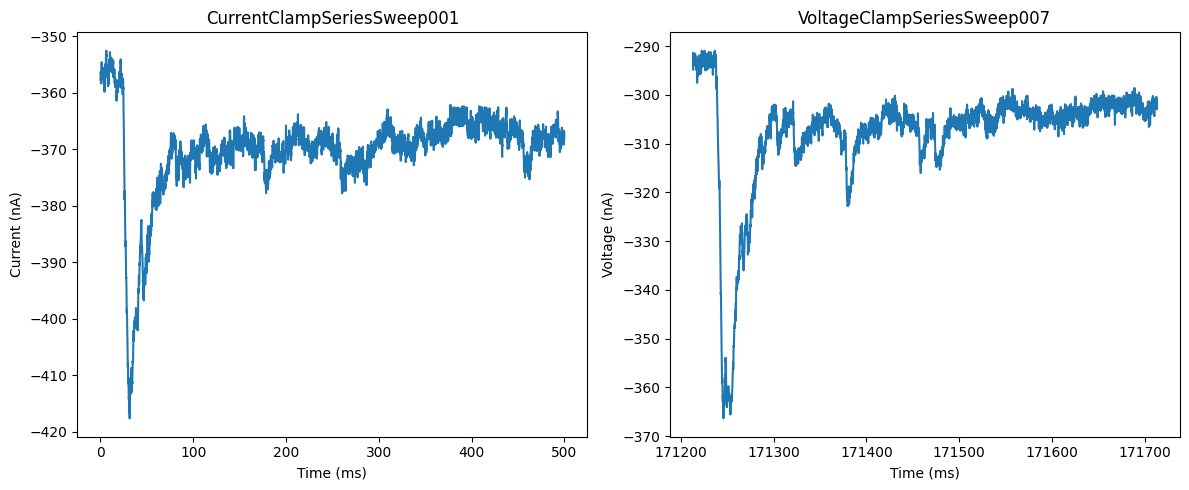

In [ ]:
import matplotlib.pyplot as plt

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

trial_index_string = "001"
trial_index_number = int(trial_index_string)

# Plot VoltageClampSeriesSweep001 on the left
voltage_clamp_response_1 = nwbfile.acquisition["VoltageClampSeriesSweep001"]
timestamps1_in_seconds = voltage_clamp_response_1.get_timestamps()
data_in_amperes = voltage_clamp_response_1.get_data_in_units()
data_in_pico_amperes = data_in_amperes * 1e12

# Show data for only 500 milliseconds
timestamps_in_milliseconds = timestamps1_in_seconds * 1000

starting_time = timestamps_in_milliseconds[0]
mask = timestamps_in_milliseconds < starting_time + 500
timestamps_in_milliseconds = timestamps_in_milliseconds[mask]
data_in_pico_amperes = data_in_pico_amperes[mask]

ax1.plot(timestamps_in_milliseconds, data_in_pico_amperes)
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel(f"Current (nA)")
ax1.set_title("CurrentClampSeriesSweep001")

# Plot VoltageClampSeriesSweep002 on the right
voltage_clamp_response_2 = nwbfile.acquisition["VoltageClampSeriesSweep007"]
timestamps_2 = voltage_clamp_response_2.get_timestamps()
data_in_amperes = voltage_clamp_response_2.get_data_in_units()
data_in_pico_amperes = data_in_amperes * 1e12

# Show data for only 500 milliseconds
timestamps_in_milliseconds = timestamps_2 * 1000
starting_time = timestamps_in_milliseconds[0]
mask = timestamps_in_milliseconds < starting_time + 500
timestamps_in_milliseconds = timestamps_in_milliseconds[mask]
data_in_pico_amperes = data_in_pico_amperes[mask]

ax2.plot(timestamps_in_milliseconds, data_in_pico_amperes)
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel(f"Voltage (nA)")
ax2.set_title("VoltageClampSeriesSweep007")

plt.tight_layout()
plt.show()

In [ ]:
optogenetics_table_df = nwbfile.intervals["optogenetic_epochs_table"].to_dataframe()
stimulation_entries_df  = optogenetics_table_df[optogenetics_table_df["stimulation_on"]  == True]
detection_entries_df = optogenetics_table_df[optogenetics_table_df["stage_name"] == "detection"]
detection_entries_df

,start_time,stop_time,stimulation_on,pulse_length_in_ms,period_in_ms,number_pulses_per_pulse_train,number_trains,intertrain_interval_in_ms,power_in_mW,optical_fiber_locations,stage_name
id,,,,,,,,,,,
0,0.00,0.020000,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,pre_stimulation
1,0.02,0.020300,True,0.3,NaN,1,1,NaN,NaN,implanted_fiber_desc...,stimulation
2,0.06,0.420000,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,detection
3,0.42,1.000000,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,post_detection
4,1.00,23.110737,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,inter_sweep_interval


,start_time,stop_time,stimulation_on,pulse_length_in_ms,period_in_ms,number_pulses_per_pulse_train,number_trains,intertrain_interval_in_ms,power_in_mW,optical_fiber_locations,stage_name
id,,,,,,,,,,,
2,0.060000,0.420000,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,detection
7,23.170737,23.530737,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,detection
12,51.289308,51.649308,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,detection
17,81.264289,81.624289,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,detection
22,111.272445,111.632445,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,detection
27,141.280397,141.640397,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,detection
32,171.273098,171.633098,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,detection
37,201.278286,201.638286,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,detection
42,231.268363,231.628363,False,NaN,NaN,-1,-1,NaN,0.0,implanted_fiber_desc...,detection


Trial 001 - Detection window analysis:
  Noise mean: -369.54 pA
  Noise standard deviation: 3.06 pA
  Positive event threshold (mean + 5*SD): -354.22 pA
  Negative event threshold (mean - 5*SD): -384.86 pA
  Number of positive events: 0
  Number of negative events: 0
  Total events detected: 0

Trial 007 - Detection window analysis:
  Noise mean: -306.74 pA
  Noise standard deviation: 4.34 pA
  Positive event threshold (mean + 5*SD): -285.05 pA
  Negative event threshold (mean - 5*SD): -328.44 pA
  Number of positive events: 0
  Number of negative events: 30
  Total events detected: 30


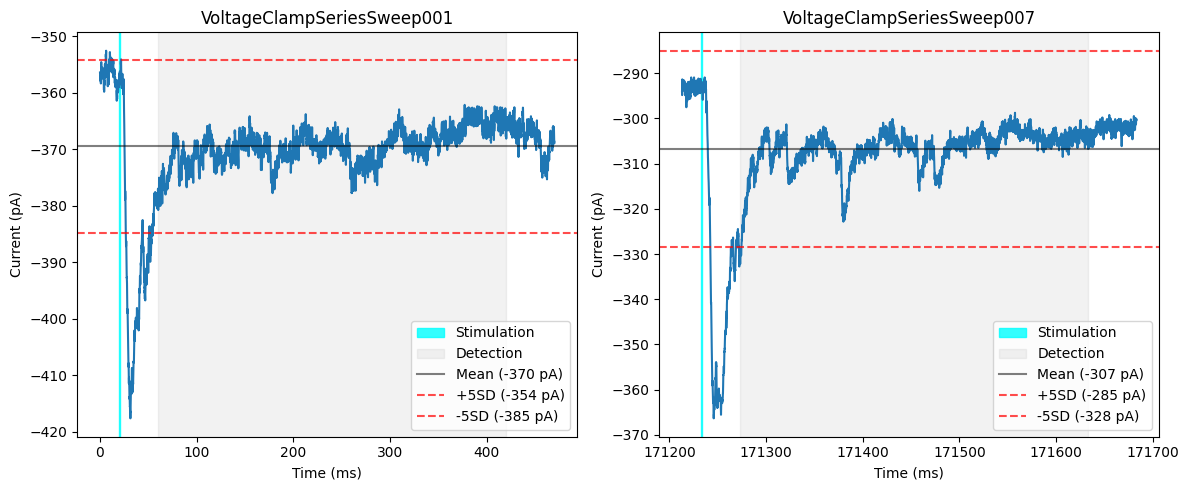

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

trial_index_string = "001"
trial_index_number = int(trial_index_string)

# Plot VoltageClampSeriesSweep001 on the left
series_name = f"VoltageClampSeriesSweep{trial_index_string}"
voltage_clamp_response_1 = nwbfile.acquisition[series_name]
timestamps1_in_seconds = voltage_clamp_response_1.get_timestamps()
data_in_amperes = voltage_clamp_response_1.get_data_in_units()
data_in_pico_amperes = data_in_amperes * 1e12

stimulation_info = stimulation_entries_df.iloc[trial_index_number - 1]
stimulation_start_seconds = stimulation_info["start_time"]
stimulation_stop_seconds = stimulation_info["stop_time"]
stimulation_start_ms = stimulation_start_seconds * 1000
stimulation_stop_ms = stimulation_stop_seconds * 1000

detection_info =  detection_entries_df.iloc[trial_index_number - 1]
detection_start_seconds = detection_info["start_time"]
detection_stop_seconds = detection_info["stop_time"]
detection_start_ms = detection_start_seconds * 1000
detection_stop_ms = detection_stop_seconds * 1000

# Show data up to 50ms after detection window ends
timestamps_in_milliseconds = timestamps1_in_seconds * 1000
starting_time = timestamps_in_milliseconds[0]
end_time = detection_stop_ms + 50
mask = (timestamps_in_milliseconds >= starting_time) & (timestamps_in_milliseconds <= end_time)
timestamps_in_milliseconds = timestamps_in_milliseconds[mask]
data_in_pico_amperes = data_in_pico_amperes[mask]

# Calculate noise statistics and detect events within detection window
detection_mask = (timestamps_in_milliseconds >= detection_start_ms) & (timestamps_in_milliseconds <= detection_stop_ms)
detection_data = data_in_pico_amperes[detection_mask]
noise_std = np.std(detection_data)
noise_mean = np.mean(detection_data)
event_threshold_positive = noise_mean + 5 * noise_std
event_threshold_negative = noise_mean - 5 * noise_std

# Find events (values > 5 SD above or below noise mean)
positive_event_indices = np.where(detection_data > event_threshold_positive)[0]
negative_event_indices = np.where(detection_data < event_threshold_negative)[0]
total_event_count = len(positive_event_indices) + len(negative_event_indices)

print(f"Trial {trial_index_string} - Detection window analysis:")
print(f"  Noise mean: {noise_mean:.2f} pA")
print(f"  Noise standard deviation: {noise_std:.2f} pA")
print(f"  Positive event threshold (mean + 5*SD): {event_threshold_positive:.2f} pA")
print(f"  Negative event threshold (mean - 5*SD): {event_threshold_negative:.2f} pA")
print(f"  Number of positive events: {len(positive_event_indices)}")
print(f"  Number of negative events: {len(negative_event_indices)}")
print(f"  Total events detected: {total_event_count}")

ax1.plot(timestamps_in_milliseconds, data_in_pico_amperes)
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel(f"Current (pA)")
ax1.set_title("VoltageClampSeriesSweep001")
ax1.axvspan(stimulation_start_ms, stimulation_stop_ms, color="cyan", alpha=0.8, label="Stimulation")
ax1.axvspan(detection_start_ms, detection_stop_ms, color="gray", alpha=0.1, label="Detection")
ax1.axhline(y=noise_mean, color='black', linestyle='-', alpha=0.5, label=f'Mean ({noise_mean:.0f} pA)')
ax1.axhline(y=event_threshold_positive, color='red', linestyle='--', alpha=0.7, label=f'+5SD ({event_threshold_positive:.0f} pA)')
ax1.axhline(y=event_threshold_negative, color='red', linestyle='--', alpha=0.7, label=f'-5SD ({event_threshold_negative:.0f} pA)')
ax1.legend()

trial_index_string = "007"
trial_index_number = int(trial_index_string)
series_name = f"VoltageClampSeriesSweep{trial_index_string}"
voltage_clamp_response_2 = nwbfile.acquisition[series_name]
timestamps_2 = voltage_clamp_response_2.get_timestamps()
data_in_amperes = voltage_clamp_response_2.get_data_in_units()
data_in_pico_amperes = data_in_amperes * 1e12

# Get stimulation and detection info for trial 7
stimulation_info_2 = stimulation_entries_df.iloc[trial_index_number - 1]
stimulation_start_seconds_2 = stimulation_info_2["start_time"]
stimulation_stop_seconds_2 = stimulation_info_2["stop_time"]
stimulation_start_ms_2 = stimulation_start_seconds_2 * 1000
stimulation_stop_ms_2 = stimulation_stop_seconds_2 * 1000

detection_info_2 = detection_entries_df.iloc[trial_index_number - 1]
detection_start_seconds_2 = detection_info_2["start_time"]
detection_stop_seconds_2 = detection_info_2["stop_time"]
detection_start_ms_2 = detection_start_seconds_2 * 1000
detection_stop_ms_2 = detection_stop_seconds_2 * 1000

# Show data up to 50ms after detection window ends
timestamps_in_milliseconds_2 = timestamps_2 * 1000
starting_time_2 = timestamps_in_milliseconds_2[0]
end_time_2 = detection_stop_ms_2 + 50
mask_2 = (timestamps_in_milliseconds_2 >= starting_time_2) & (timestamps_in_milliseconds_2 <= end_time_2)
timestamps_in_milliseconds_2 = timestamps_in_milliseconds_2[mask_2]
data_in_pico_amperes_2 = data_in_pico_amperes[mask_2]

# Calculate noise statistics and detect events within detection window for trial 7
detection_mask_2 = (timestamps_in_milliseconds_2 >= detection_start_ms_2) & (timestamps_in_milliseconds_2 <= detection_stop_ms_2)
detection_data_2 = data_in_pico_amperes_2[detection_mask_2]
noise_std_2 = np.std(detection_data_2)
noise_mean_2 = np.mean(detection_data_2)
event_threshold_positive_2 = noise_mean_2 + 5 * noise_std_2
event_threshold_negative_2 = noise_mean_2 - 5 * noise_std_2

# Find events (values > 5 SD above or below noise mean)
positive_event_indices_2 = np.where(detection_data_2 > event_threshold_positive_2)[0]
negative_event_indices_2 = np.where(detection_data_2 < event_threshold_negative_2)[0]
total_event_count_2 = len(positive_event_indices_2) + len(negative_event_indices_2)

print(f"\nTrial {trial_index_string} - Detection window analysis:")
print(f"  Noise mean: {noise_mean_2:.2f} pA")
print(f"  Noise standard deviation: {noise_std_2:.2f} pA")
print(f"  Positive event threshold (mean + 5*SD): {event_threshold_positive_2:.2f} pA")
print(f"  Negative event threshold (mean - 5*SD): {event_threshold_negative_2:.2f} pA")
print(f"  Number of positive events: {len(positive_event_indices_2)}")
print(f"  Number of negative events: {len(negative_event_indices_2)}")
print(f"  Total events detected: {total_event_count_2}")

ax2.plot(timestamps_in_milliseconds_2, data_in_pico_amperes_2)
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel(f"Current (pA)")
ax2.set_title("VoltageClampSeriesSweep007")
ax2.axvspan(stimulation_start_ms_2, stimulation_stop_ms_2, color="cyan", alpha=0.8, label="Stimulation")
ax2.axvspan(detection_start_ms_2, detection_stop_ms_2, color="gray", alpha=0.1, label="Detection")
ax2.axhline(y=noise_mean_2, color='black', linestyle='-', alpha=0.5, label=f'Mean ({noise_mean_2:.0f} pA)')
ax2.axhline(y=event_threshold_positive_2, color='red', linestyle='--', alpha=0.7, label=f'+5SD ({event_threshold_positive_2:.0f} pA)')
ax2.axhline(y=event_threshold_negative_2, color='red', linestyle='--', alpha=0.7, label=f'-5SD ({event_threshold_negative_2:.0f} pA)')
ax2.legend()

plt.tight_layout()
plt.show()

Trial 001 - Detection window analysis:
  Noise mean: -369.54 pA
  Noise standard deviation: 3.06 pA
  Positive event threshold (mean + 5*SD): -354.22 pA
  Negative event threshold (mean - 5*SD): -384.86 pA
  Number of positive events: 0
  Number of negative events: 0
  Total events detected: 0

Trial 007 - Detection window analysis:
  Noise mean: -306.74 pA
  Noise standard deviation: 4.34 pA
  Positive event threshold (mean + 5*SD): -285.05 pA
  Negative event threshold (mean - 5*SD): -328.44 pA
  Number of positive events: 0
  Number of negative events: 30
  Total events detected: 30


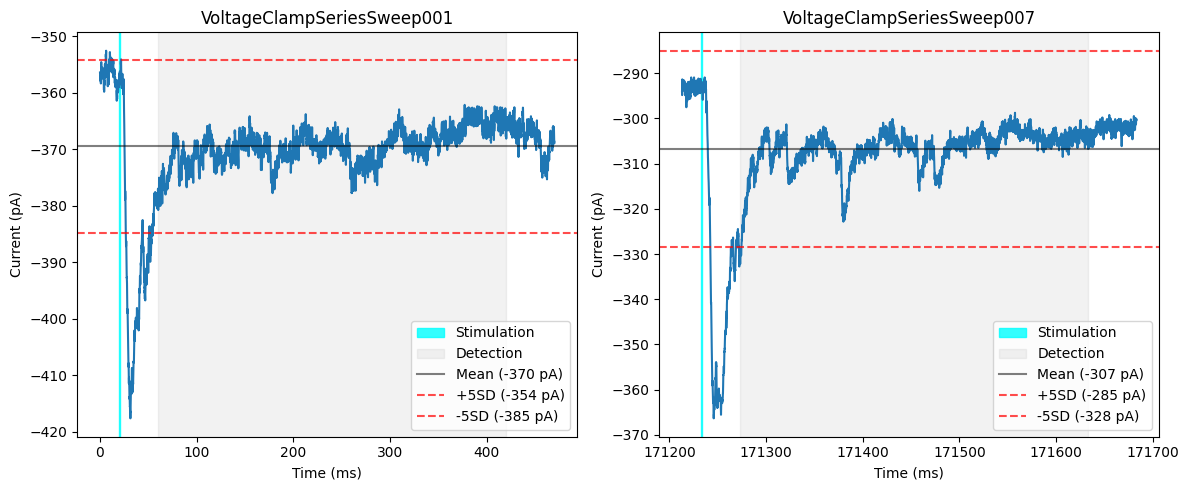

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

trial_index_string = "001"
trial_index_number = int(trial_index_string)

# Plot VoltageClampSeriesSweep001 on the left
series_name = f"VoltageClampSeriesSweep{trial_index_string}"
voltage_clamp_response_1 = nwbfile.acquisition[series_name]
timestamps1_in_seconds = voltage_clamp_response_1.get_timestamps()
data_in_amperes = voltage_clamp_response_1.get_data_in_units()
data_in_pico_amperes = data_in_amperes * 1e12

stimulation_info = stimulation_entries_df.iloc[trial_index_number - 1]
stimulation_start_seconds = stimulation_info["start_time"]
stimulation_stop_seconds = stimulation_info["stop_time"]
stimulation_start_ms = stimulation_start_seconds * 1000
stimulation_stop_ms = stimulation_stop_seconds * 1000

detection_info =  detection_entries_df.iloc[trial_index_number - 1]
detection_start_seconds = detection_info["start_time"]
detection_stop_seconds = detection_info["stop_time"]
detection_start_ms = detection_start_seconds * 1000
detection_stop_ms = detection_stop_seconds * 1000

# Show data up to 50ms after detection window ends
timestamps_in_milliseconds = timestamps1_in_seconds * 1000
starting_time = timestamps_in_milliseconds[0]
end_time = detection_stop_ms + 50
mask = (timestamps_in_milliseconds >= starting_time) & (timestamps_in_milliseconds <= end_time)
timestamps_in_milliseconds = timestamps_in_milliseconds[mask]
data_in_pico_amperes = data_in_pico_amperes[mask]

# Calculate noise statistics and detect events within detection window
detection_mask = (timestamps_in_milliseconds >= detection_start_ms) & (timestamps_in_milliseconds <= detection_stop_ms)
detection_data = data_in_pico_amperes[detection_mask]
noise_std = np.std(detection_data)
noise_mean = np.mean(detection_data)
event_threshold_positive = noise_mean + 5 * noise_std
event_threshold_negative = noise_mean - 5 * noise_std

# Find events (values > 5 SD above or below noise mean)
positive_event_indices = np.where(detection_data > event_threshold_positive)[0]
negative_event_indices = np.where(detection_data < event_threshold_negative)[0]
total_event_count = len(positive_event_indices) + len(negative_event_indices)

print(f"Trial {trial_index_string} - Detection window analysis:")
print(f"  Noise mean: {noise_mean:.2f} pA")
print(f"  Noise standard deviation: {noise_std:.2f} pA")
print(f"  Positive event threshold (mean + 5*SD): {event_threshold_positive:.2f} pA")
print(f"  Negative event threshold (mean - 5*SD): {event_threshold_negative:.2f} pA")
print(f"  Number of positive events: {len(positive_event_indices)}")
print(f"  Number of negative events: {len(negative_event_indices)}")
print(f"  Total events detected: {total_event_count}")

ax1.plot(timestamps_in_milliseconds, data_in_pico_amperes)
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel(f"Current (pA)")
ax1.set_title("VoltageClampSeriesSweep001")
ax1.axvspan(stimulation_start_ms, stimulation_stop_ms, color="cyan", alpha=0.8, label="Stimulation")
ax1.axvspan(detection_start_ms, detection_stop_ms, color="gray", alpha=0.1, label="Detection")
ax1.axhline(y=noise_mean, color='black', linestyle='-', alpha=0.5, label=f'Mean ({noise_mean:.0f} pA)')
ax1.axhline(y=event_threshold_positive, color='red', linestyle='--', alpha=0.7, label=f'+5SD ({event_threshold_positive:.0f} pA)')
ax1.axhline(y=event_threshold_negative, color='red', linestyle='--', alpha=0.7, label=f'-5SD ({event_threshold_negative:.0f} pA)')
ax1.legend()

trial_index_string = "007"
trial_index_number = int(trial_index_string)
series_name = f"VoltageClampSeriesSweep{trial_index_string}"
voltage_clamp_response_2 = nwbfile.acquisition[series_name]
timestamps_2 = voltage_clamp_response_2.get_timestamps()
data_in_amperes = voltage_clamp_response_2.get_data_in_units()
data_in_pico_amperes = data_in_amperes * 1e12

# Get stimulation and detection info for trial 7
stimulation_info_2 = stimulation_entries_df.iloc[trial_index_number - 1]
stimulation_start_seconds_2 = stimulation_info_2["start_time"]
stimulation_stop_seconds_2 = stimulation_info_2["stop_time"]
stimulation_start_ms_2 = stimulation_start_seconds_2 * 1000
stimulation_stop_ms_2 = stimulation_stop_seconds_2 * 1000

detection_info_2 = detection_entries_df.iloc[trial_index_number - 1]
detection_start_seconds_2 = detection_info_2["start_time"]
detection_stop_seconds_2 = detection_info_2["stop_time"]
detection_start_ms_2 = detection_start_seconds_2 * 1000
detection_stop_ms_2 = detection_stop_seconds_2 * 1000

# Show data up to 50ms after detection window ends
timestamps_in_milliseconds_2 = timestamps_2 * 1000
starting_time_2 = timestamps_in_milliseconds_2[0]
end_time_2 = detection_stop_ms_2 + 50
mask_2 = (timestamps_in_milliseconds_2 >= starting_time_2) & (timestamps_in_milliseconds_2 <= end_time_2)
timestamps_in_milliseconds_2 = timestamps_in_milliseconds_2[mask_2]
data_in_pico_amperes_2 = data_in_pico_amperes[mask_2]

# Calculate noise statistics and detect events within detection window for trial 7
detection_mask_2 = (timestamps_in_milliseconds_2 >= detection_start_ms_2) & (timestamps_in_milliseconds_2 <= detection_stop_ms_2)
detection_data_2 = data_in_pico_amperes_2[detection_mask_2]
noise_std_2 = np.std(detection_data_2)
noise_mean_2 = np.mean(detection_data_2)
event_threshold_positive_2 = noise_mean_2 + 5 * noise_std_2
event_threshold_negative_2 = noise_mean_2 - 5 * noise_std_2

# Find events (values > 5 SD above or below noise mean)
positive_event_indices_2 = np.where(detection_data_2 > event_threshold_positive_2)[0]
negative_event_indices_2 = np.where(detection_data_2 < event_threshold_negative_2)[0]
total_event_count_2 = len(positive_event_indices_2) + len(negative_event_indices_2)

print(f"\nTrial {trial_index_string} - Detection window analysis:")
print(f"  Noise mean: {noise_mean_2:.2f} pA")
print(f"  Noise standard deviation: {noise_std_2:.2f} pA")
print(f"  Positive event threshold (mean + 5*SD): {event_threshold_positive_2:.2f} pA")
print(f"  Negative event threshold (mean - 5*SD): {event_threshold_negative_2:.2f} pA")
print(f"  Number of positive events: {len(positive_event_indices_2)}")
print(f"  Number of negative events: {len(negative_event_indices_2)}")
print(f"  Total events detected: {total_event_count_2}")

ax2.plot(timestamps_in_milliseconds_2, data_in_pico_amperes_2)
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel(f"Current (pA)")
ax2.set_title("VoltageClampSeriesSweep007")
ax2.axvspan(stimulation_start_ms_2, stimulation_stop_ms_2, color="cyan", alpha=0.8, label="Stimulation")
ax2.axvspan(detection_start_ms_2, detection_stop_ms_2, color="gray", alpha=0.1, label="Detection")
ax2.axhline(y=noise_mean_2, color='black', linestyle='-', alpha=0.5, label=f'Mean ({noise_mean_2:.0f} pA)')
ax2.axhline(y=event_threshold_positive_2, color='red', linestyle='--', alpha=0.7, label=f'+5SD ({event_threshold_positive_2:.0f} pA)')
ax2.axhline(y=event_threshold_negative_2, color='red', linestyle='--', alpha=0.7, label=f'-5SD ({event_threshold_negative_2:.0f} pA)')
ax2.legend()

plt.tight_layout()
plt.show()

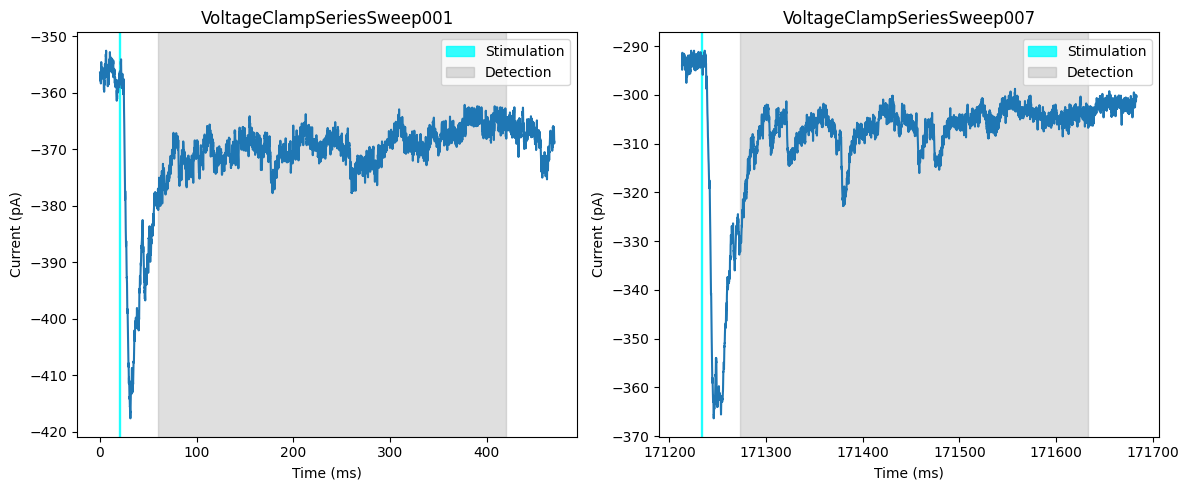

In [65]:
import matplotlib.pyplot as plt

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

trial_index_string = "001"
trial_index_number = int(trial_index_string)

# Plot VoltageClampSeriesSweep001 on the left
series_name = f"VoltageClampSeriesSweep{trial_index_string}"
voltage_clamp_response_1 = nwbfile.acquisition[series_name]
timestamps1_in_seconds = voltage_clamp_response_1.get_timestamps()
data_in_amperes = voltage_clamp_response_1.get_data_in_units()
data_in_pico_amperes = data_in_amperes * 1e12

stimulation_info = stimulation_entries_df.iloc[trial_index_number - 1]
stimulation_start_seconds = stimulation_info["start_time"]
stimulation_stop_seconds = stimulation_info["stop_time"]
stimulation_start_ms = stimulation_start_seconds * 1000
stimulation_stop_ms = stimulation_stop_seconds * 1000

detection_info =  detection_entries_df.iloc[trial_index_number - 1]
detection_start_seconds = detection_info["start_time"]
detection_stop_seconds = detection_info["stop_time"]
detection_start_ms = detection_start_seconds * 1000
detection_stop_ms = detection_stop_seconds * 1000

# Show data up to 50ms after detection window ends
timestamps_in_milliseconds = timestamps1_in_seconds * 1000
starting_time = timestamps_in_milliseconds[0]
end_time = detection_stop_ms + 50
mask = (timestamps_in_milliseconds >= starting_time) & (timestamps_in_milliseconds <= end_time)
timestamps_in_milliseconds = timestamps_in_milliseconds[mask]
data_in_pico_amperes = data_in_pico_amperes[mask]

ax1.plot(timestamps_in_milliseconds, data_in_pico_amperes)
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel(f"Current (pA)")
ax1.set_title("VoltageClampSeriesSweep001")
ax1.axvspan(stimulation_start_ms, stimulation_stop_ms, color="cyan", alpha=0.8, label="Stimulation")
ax1.axvspan(detection_start_ms, detection_stop_ms, color="gray", alpha=0.25, label="Detection")
ax1.legend()

trial_index_string = "007"
trial_index_number = int(trial_index_string)
series_name = f"VoltageClampSeriesSweep{trial_index_string}"
voltage_clamp_response_2 = nwbfile.acquisition[series_name]
timestamps_2 = voltage_clamp_response_2.get_timestamps()
data_in_amperes = voltage_clamp_response_2.get_data_in_units()
data_in_pico_amperes = data_in_amperes * 1e12

# Get stimulation and detection info for trial 7
stimulation_info_2 = stimulation_entries_df.iloc[trial_index_number - 1]
stimulation_start_seconds_2 = stimulation_info_2["start_time"]
stimulation_stop_seconds_2 = stimulation_info_2["stop_time"]
stimulation_start_ms_2 = stimulation_start_seconds_2 * 1000
stimulation_stop_ms_2 = stimulation_stop_seconds_2 * 1000

detection_info_2 = detection_entries_df.iloc[trial_index_number - 1]
detection_start_seconds_2 = detection_info_2["start_time"]
detection_stop_seconds_2 = detection_info_2["stop_time"]
detection_start_ms_2 = detection_start_seconds_2 * 1000
detection_stop_ms_2 = detection_stop_seconds_2 * 1000

# Show data up to 50ms after detection window ends
timestamps_in_milliseconds_2 = timestamps_2 * 1000
starting_time_2 = timestamps_in_milliseconds_2[0]
end_time_2 = detection_stop_ms_2 + 50
mask_2 = (timestamps_in_milliseconds_2 >= starting_time_2) & (timestamps_in_milliseconds_2 <= end_time_2)
timestamps_in_milliseconds_2 = timestamps_in_milliseconds_2[mask_2]
data_in_pico_amperes_2 = data_in_pico_amperes[mask_2]

ax2.plot(timestamps_in_milliseconds_2, data_in_pico_amperes_2)
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel(f"Current (pA)")
ax2.set_title("VoltageClampSeriesSweep007")
ax2.axvspan(stimulation_start_ms_2, stimulation_stop_ms_2, color="cyan", alpha=0.8, label="Stimulation")
ax2.axvspan(detection_start_ms_2, detection_stop_ms_2, color="gray", alpha=0.25, label="Detection")
ax2.legend()

plt.tight_layout()
plt.show()

In [42]:
stimulation_stop_ms

np.float64(20.3)

## With merge

VoltageClampSeriesSweep001 - MAD-STD: 2.71 pA, Median: -368.77 pA, Events: 0
VoltageClampSeriesSweep002 - MAD-STD: 2.94 pA, Median: -357.12 pA, Events: 0
VoltageClampSeriesSweep003 - MAD-STD: 1.81 pA, Median: -349.12 pA
  Raw events: +0, -2 = 2
  Merged events: +0, -1 = 1
  Negative merged amplitudes: ['10.7'] pA
VoltageClampSeriesSweep004 - MAD-STD: 2.81 pA, Median: -368.90 pA
  Raw events: +0, -187 = 187
  Merged events: +0, -10 = 10
  Negative merged amplitudes: ['30.2', '33.7', '36.9', '35.6', '31.1', '27.3', '24.2', '23.3', '18.1', '17.5'] pA
VoltageClampSeriesSweep005 - MAD-STD: 1.54 pA, Median: -342.96 pA, Events: 0
VoltageClampSeriesSweep006 - MAD-STD: 3.44 pA, Median: -333.56 pA, Events: 0
VoltageClampSeriesSweep007 - MAD-STD: 2.44 pA, Median: -305.24 pA
  Raw events: +0, -106 = 106
  Merged events: +0, -6 = 6
  Negative merged amplitudes: ['17.0', '17.6', '17.2', '15.7', '14.3', '13.0'] pA
VoltageClampSeriesSweep008 - MAD-STD: 2.08 pA, Median: -297.91 pA
  Raw events: +0, -2 

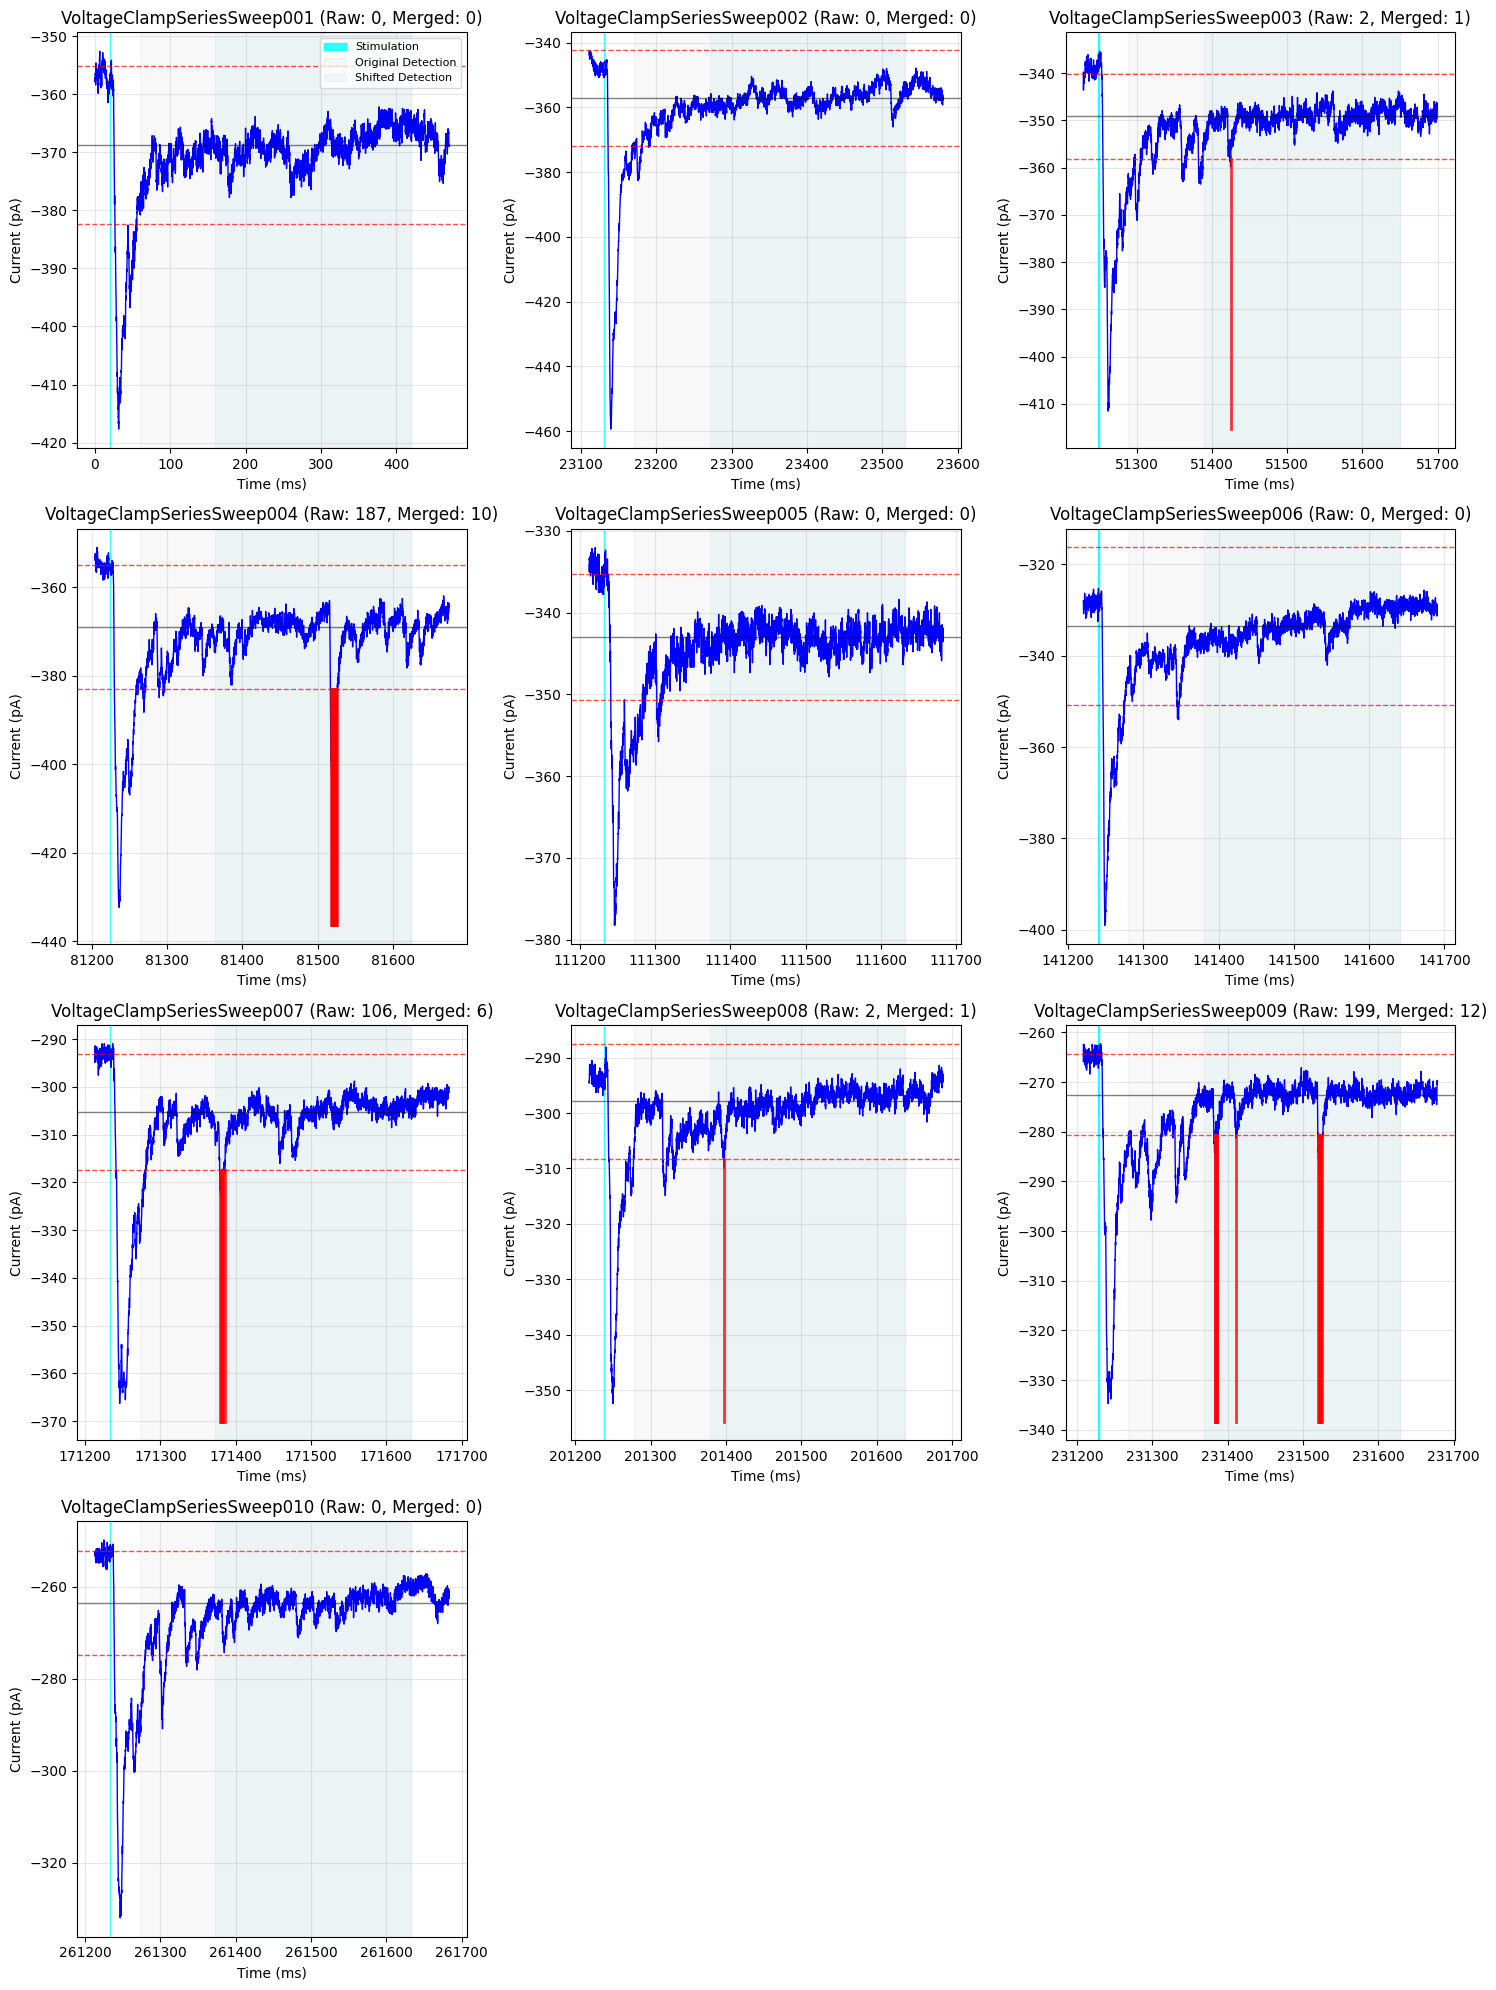


=== EVENT AMPLITUDE SUMMARY ===
Merge distance: 1.0 ms

RAW EVENTS:
  Total: 496 (Positive: 0, Negative: 496)

MERGED EVENTS:
  Total: 30 (Positive: 0, Negative: 30)

Merged event amplitude statistics:
  Mean: 17.80 pA
  Median: 15.56 pA
  Std: 8.33 pA
  Min: 8.67 pA
  Max: 36.87 pA

Detection window shifted by 100 ms from original start


In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Control parameters
detection_window_shift_ms = 100  # Shift detection window start by this many ms after original start
event_merge_distance_ms = 1.0    # Merge events within this distance (milliseconds)

def merge_nearby_events(event_times, event_amplitudes, merge_distance_ms):
    """
    Merge events that are within merge_distance_ms of each other.
    For merged events, keep the one with maximum amplitude.
    """
    if len(event_times) == 0:
        return event_times, event_amplitudes
    
    # Convert to numpy arrays for easier manipulation
    times = np.array(event_times)
    amplitudes = np.array(event_amplitudes)
    
    # Sort by time
    sorted_indices = np.argsort(times)
    times = times[sorted_indices]
    amplitudes = amplitudes[sorted_indices]
    
    merged_times = []
    merged_amplitudes = []
    
    i = 0
    while i < len(times):
        current_time = times[i]
        current_amp = amplitudes[i]
        
        # Find all events within merge_distance_ms
        j = i + 1
        max_amp = current_amp
        max_amp_time = current_time
        
        while j < len(times) and (times[j] - current_time) <= merge_distance_ms:
            if amplitudes[j] > max_amp:
                max_amp = amplitudes[j]
                max_amp_time = times[j]
            j += 1
        
        # Add the event with maximum amplitude
        merged_times.append(max_amp_time)
        merged_amplitudes.append(max_amp)
        
        # Skip all events that were merged
        i = j
    
    return merged_times, merged_amplitudes

# Get all acquisition keys
acquisition_keys = list(nwbfile.acquisition.keys())
num_sweeps = len(acquisition_keys)

# Initialize lists to collect event amplitudes
all_positive_amplitudes = []
all_negative_amplitudes = []
all_event_amplitudes = []

# Initialize lists for merged events
all_positive_amplitudes_merged = []
all_negative_amplitudes_merged = []
all_event_amplitudes_merged = []

# Calculate grid dimensions
cols = 3
rows = (num_sweeps + cols - 1) // cols

# Create subplots grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten() if num_sweeps > 1 else [axes]

# Process each sweep
for i, sweep_key in enumerate(acquisition_keys):
    # Extract trial number from key
    trial_number = int(sweep_key.split('Sweep')[-1])
    
    # Get voltage clamp response
    voltage_clamp_response = nwbfile.acquisition[sweep_key]
    timestamps_in_seconds = voltage_clamp_response.get_timestamps()
    data_in_amperes = voltage_clamp_response.get_data_in_units()
    data_in_pico_amperes = data_in_amperes * 1e12
    
    # Get stimulation and detection info for this trial
    stimulation_info = stimulation_entries_df.iloc[trial_number - 1]
    stimulation_start_ms = stimulation_info["start_time"] * 1000
    stimulation_stop_ms = stimulation_info["stop_time"] * 1000
    
    detection_info = detection_entries_df.iloc[trial_number - 1]
    detection_start_ms_original = detection_info["start_time"] * 1000
    detection_stop_ms = detection_info["stop_time"] * 1000
    
    # Apply shift to detection window start
    detection_start_ms_shifted = detection_start_ms_original + detection_window_shift_ms
    
    # Show data up to 50ms after detection window ends
    timestamps_in_milliseconds = timestamps_in_seconds * 1000
    starting_time = timestamps_in_milliseconds[0]
    end_time = detection_stop_ms + 50
    mask = (timestamps_in_milliseconds >= starting_time) & (timestamps_in_milliseconds <= end_time)
    timestamps_filtered = timestamps_in_milliseconds[mask]
    data_filtered = data_in_pico_amperes[mask]
    
    # Calculate noise statistics within shifted detection window using MAD
    detection_mask = (timestamps_filtered >= detection_start_ms_shifted) & (timestamps_filtered <= detection_stop_ms)
    detection_data = data_filtered[detection_mask]
    detection_timestamps = timestamps_filtered[detection_mask]
    
    # Calculate MAD-based standard deviation
    noise_median = np.median(detection_data)
    mad = np.median(np.abs(detection_data - noise_median))
    # Convert MAD to standard deviation estimate (assuming normal distribution)
    mad_std = mad * 1.4826  # MAD to std conversion factor for normal distribution
    
    event_threshold_positive = noise_median + 5 * mad_std
    event_threshold_negative = noise_median - 5 * mad_std
    
    # Find events and their timestamps
    positive_event_indices = np.where(detection_data > event_threshold_positive)[0]
    negative_event_indices = np.where(detection_data < event_threshold_negative)[0]
    
    # Get event timestamps and amplitudes (raw)
    positive_event_times_raw = detection_timestamps[positive_event_indices] if len(positive_event_indices) > 0 else []
    negative_event_times_raw = detection_timestamps[negative_event_indices] if len(negative_event_indices) > 0 else []
    
    # Calculate event amplitudes (deviation from median)
    positive_event_amplitudes_raw = detection_data[positive_event_indices] - noise_median if len(positive_event_indices) > 0 else []
    negative_event_amplitudes_raw = noise_median - detection_data[negative_event_indices] if len(negative_event_indices) > 0 else []
    
    # Merge nearby events
    positive_event_times_merged, positive_event_amplitudes_merged = merge_nearby_events(
        positive_event_times_raw, positive_event_amplitudes_raw, event_merge_distance_ms)
    negative_event_times_merged, negative_event_amplitudes_merged = merge_nearby_events(
        negative_event_times_raw, negative_event_amplitudes_raw, event_merge_distance_ms)
    
    # Collect raw amplitudes in global lists
    if len(positive_event_amplitudes_raw) > 0:
        all_positive_amplitudes.extend(positive_event_amplitudes_raw)
        all_event_amplitudes.extend(positive_event_amplitudes_raw)
    
    if len(negative_event_amplitudes_raw) > 0:
        all_negative_amplitudes.extend(negative_event_amplitudes_raw)
        all_event_amplitudes.extend(negative_event_amplitudes_raw)
    
    # Collect merged amplitudes in global lists
    if len(positive_event_amplitudes_merged) > 0:
        all_positive_amplitudes_merged.extend(positive_event_amplitudes_merged)
        all_event_amplitudes_merged.extend(positive_event_amplitudes_merged)
    
    if len(negative_event_amplitudes_merged) > 0:
        all_negative_amplitudes_merged.extend(negative_event_amplitudes_merged)
        all_event_amplitudes_merged.extend(negative_event_amplitudes_merged)
    
    total_events_raw = len(positive_event_times_raw) + len(negative_event_times_raw)
    total_events_merged = len(positive_event_times_merged) + len(negative_event_times_merged)
    
    # Plot
    ax = axes[i]
    ax.plot(timestamps_filtered, data_filtered, 'b-', linewidth=1)
    ax.axvspan(stimulation_start_ms, stimulation_stop_ms, color="cyan", alpha=0.8, label="Stimulation")
    ax.axvspan(detection_start_ms_original, detection_stop_ms, color="gray", alpha=0.05, label="Original Detection")
    ax.axvspan(detection_start_ms_shifted, detection_stop_ms, color="lightblue", alpha=0.15, label="Shifted Detection")
    ax.axhline(y=noise_median, color='black', linestyle='-', alpha=0.5, linewidth=1)
    ax.axhline(y=event_threshold_positive, color='red', linestyle='--', alpha=0.7, linewidth=1)
    ax.axhline(y=event_threshold_negative, color='red', linestyle='--', alpha=0.7, linewidth=1)
    
    # Get plot limits for scaling event markers
    y_min, y_max = ax.get_ylim() if len(data_filtered) > 0 else (min(data_filtered), max(data_filtered))
    
    # Add vertical lines for merged positive events (from top to positive threshold)
    for event_time in positive_event_times_merged:
        ax.plot([event_time, event_time], [event_threshold_positive, y_max], 
                color='red', alpha=0.8, linewidth=2)
    
    # Add vertical lines for merged negative events (from bottom to negative threshold)
    for event_time in negative_event_times_merged:
        ax.plot([event_time, event_time], [y_min, event_threshold_negative], 
                color='red', alpha=0.8, linewidth=2)
    
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Current (pA)")
    ax.set_title(f"{sweep_key} (Raw: {total_events_raw}, Merged: {total_events_merged})")
    ax.grid(True, alpha=0.3)
    
    # Add legend only to first subplot
    if i == 0:
        ax.legend(loc='upper right', fontsize=8)
    
    # Print event information for this sweep
    if total_events_raw > 0:
        print(f"{sweep_key} - MAD-STD: {mad_std:.2f} pA, Median: {noise_median:.2f} pA")
        print(f"  Raw events: +{len(positive_event_amplitudes_raw)}, -{len(negative_event_amplitudes_raw)} = {total_events_raw}")
        print(f"  Merged events: +{len(positive_event_amplitudes_merged)}, -{len(negative_event_amplitudes_merged)} = {total_events_merged}")
        if len(positive_event_amplitudes_merged) > 0:
            print(f"  Positive merged amplitudes: {[f'{amp:.1f}' for amp in positive_event_amplitudes_merged]} pA")
        if len(negative_event_amplitudes_merged) > 0:
            print(f"  Negative merged amplitudes: {[f'{amp:.1f}' for amp in negative_event_amplitudes_merged]} pA")
    else:
        print(f"{sweep_key} - MAD-STD: {mad_std:.2f} pA, Median: {noise_median:.2f} pA, Events: 0")

# Hide empty subplots
for i in range(num_sweeps, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== EVENT AMPLITUDE SUMMARY ===")
print(f"Merge distance: {event_merge_distance_ms} ms")
print(f"\nRAW EVENTS:")
print(f"  Total: {len(all_event_amplitudes)} (Positive: {len(all_positive_amplitudes)}, Negative: {len(all_negative_amplitudes)})")

print(f"\nMERGED EVENTS:")
print(f"  Total: {len(all_event_amplitudes_merged)} (Positive: {len(all_positive_amplitudes_merged)}, Negative: {len(all_negative_amplitudes_merged)})")

if len(all_event_amplitudes_merged) > 0:
    print(f"\nMerged event amplitude statistics:")
    print(f"  Mean: {np.mean(all_event_amplitudes_merged):.2f} pA")
    print(f"  Median: {np.median(all_event_amplitudes_merged):.2f} pA")
    print(f"  Std: {np.std(all_event_amplitudes_merged):.2f} pA")
    print(f"  Min: {np.min(all_event_amplitudes_merged):.2f} pA")
    print(f"  Max: {np.max(all_event_amplitudes_merged):.2f} pA")

print(f"\nDetection window shifted by {detection_window_shift_ms} ms from original start")

In [84]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import remfile
from pynwb import NWBHDF5IO

# Control parameters
detection_window_shift_ms = 100  # Shift detection window start by this many ms after original start
event_merge_distance_ms = 1.0    # Merge events within this distance (milliseconds)

def merge_nearby_events(event_times, event_amplitudes, merge_distance_ms):
    """
    Merge events that are within merge_distance_ms of each other.
    For merged events, keep the one with maximum amplitude.
    """
    if len(event_times) == 0:
        return event_times, event_amplitudes
    
    # Convert to numpy arrays for easier manipulation
    times = np.array(event_times)
    amplitudes = np.array(event_amplitudes)
    
    # Sort by time
    sorted_indices = np.argsort(times)
    times = times[sorted_indices]
    amplitudes = amplitudes[sorted_indices]
    
    merged_times = []
    merged_amplitudes = []
    
    i = 0
    while i < len(times):
        current_time = times[i]
        current_amp = amplitudes[i]
        
        # Find all events within merge_distance_ms
        j = i + 1
        max_amp = current_amp
        max_amp_time = current_time
        
        while j < len(times) and (times[j] - current_time) <= merge_distance_ms:
            if amplitudes[j] > max_amp:
                max_amp = amplitudes[j]
                max_amp_time = times[j]
            j += 1
        
        # Add the event with maximum amplitude
        merged_times.append(max_amp_time)
        merged_amplitudes.append(max_amp)
        
        # Skip all events that were merged
        i = j
    
    return merged_times, merged_amplitudes

def process_nwb_file_for_events(asset):
    """Process a single NWB file and return event amplitudes"""
    try:
        # Load NWB file
        s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)
        file_system = remfile.File(s3_url)
        file = h5py.File(file_system, mode="r")
        io = NWBHDF5IO(file=file)
        nwbfile = io.read()
        
        # Get optogenetics table
        optogenetics_table_df = nwbfile.intervals["optogenetic_epochs_table"].to_dataframe()
        stimulation_entries_df = optogenetics_table_df[optogenetics_table_df["stimulation_on"] == True]
        detection_entries_df = optogenetics_table_df[optogenetics_table_df["stage_name"] == "detection"]
        
        # Get all acquisition keys
        acquisition_keys = list(nwbfile.acquisition.keys())
        
        # Initialize lists for this file
        file_positive_amplitudes = []
        file_negative_amplitudes = []
        
        # Process each sweep
        for sweep_key in acquisition_keys:
            # Extract trial number from key
            trial_number = int(sweep_key.split('Sweep')[-1])
            
            # Get voltage clamp response
            voltage_clamp_response = nwbfile.acquisition[sweep_key]
            timestamps_in_seconds = voltage_clamp_response.get_timestamps()
            data_in_amperes = voltage_clamp_response.get_data_in_units()
            data_in_pico_amperes = data_in_amperes * 1e12
            
            # Get stimulation and detection info for this trial
            if trial_number <= len(stimulation_entries_df) and trial_number <= len(detection_entries_df):
                stimulation_info = stimulation_entries_df.iloc[trial_number - 1]
                detection_info = detection_entries_df.iloc[trial_number - 1]
                
                detection_start_ms_original = detection_info["start_time"] * 1000
                detection_stop_ms = detection_info["stop_time"] * 1000
                detection_start_ms_shifted = detection_start_ms_original + detection_window_shift_ms
                
                # Filter data to detection window
                timestamps_in_milliseconds = timestamps_in_seconds * 1000
                detection_mask = (timestamps_in_milliseconds >= detection_start_ms_shifted) & (timestamps_in_milliseconds <= detection_stop_ms)
                detection_data = data_in_pico_amperes[detection_mask]
                detection_timestamps = timestamps_in_milliseconds[detection_mask]
                
                if len(detection_data) > 0:
                    # Calculate MAD-based standard deviation
                    noise_median = np.median(detection_data)
                    mad = np.median(np.abs(detection_data - noise_median))
                    mad_std = mad * 1.4826  # MAD to std conversion factor
                    
                    event_threshold_positive = noise_median + 5 * mad_std
                    event_threshold_negative = noise_median - 5 * mad_std
                    
                    # Find events
                    positive_event_indices = np.where(detection_data > event_threshold_positive)[0]
                    negative_event_indices = np.where(detection_data < event_threshold_negative)[0]
                    
                    # Calculate amplitudes
                    positive_event_times_raw = detection_timestamps[positive_event_indices] if len(positive_event_indices) > 0 else []
                    negative_event_times_raw = detection_timestamps[negative_event_indices] if len(negative_event_indices) > 0 else []
                    
                    positive_event_amplitudes_raw = detection_data[positive_event_indices] - noise_median if len(positive_event_indices) > 0 else []
                    negative_event_amplitudes_raw = noise_median - detection_data[negative_event_indices] if len(negative_event_indices) > 0 else []
                    
                    # Merge nearby events
                    positive_event_times_merged, positive_event_amplitudes_merged = merge_nearby_events(
                        positive_event_times_raw, positive_event_amplitudes_raw, event_merge_distance_ms)
                    negative_event_times_merged, negative_event_amplitudes_merged = merge_nearby_events(
                        negative_event_times_raw, negative_event_amplitudes_raw, event_merge_distance_ms)
                    
                    # Collect merged amplitudes
                    file_positive_amplitudes.extend(positive_event_amplitudes_merged)
                    file_negative_amplitudes.extend(negative_event_amplitudes_merged)
        
        # Close file
        io.close()
        file.close()
        
        return file_positive_amplitudes, file_negative_amplitudes
        
    except Exception as e:
        print(f"Error processing {asset.path}: {e}")
        return [], []

# Filter assets for OnState and OffState
criteria_offstate = lambda asset: (is_figure_number(get_session_id(asset.path), "F2") and 
                                   is_measurement(get_session_id(asset.path), "oEPSC") and 
                                   is_state(get_session_id(asset.path), "OffState"))

criteria_onstate = lambda asset: (is_figure_number(get_session_id(asset.path), "F2") and 
                                  is_measurement(get_session_id(asset.path), "oEPSC") and 
                                  is_state(get_session_id(asset.path), "OnState"))

offstate_assets = [asset for asset in assets_list if criteria_offstate(asset)]
onstate_assets = [asset for asset in assets_list if criteria_onstate(asset)]

print(f"Found {len(offstate_assets)} OffState oEPSC assets from Figure 2")
print(f"Found {len(onstate_assets)} OnState oEPSC assets from Figure 2")

# Initialize results dictionary
event_amplitudes_by_state = {
    "OffState": {
        "positive_amplitudes": [],
        "negative_amplitudes": [],
        "all_amplitudes": []
    },
    "OnState": {
        "positive_amplitudes": [],
        "negative_amplitudes": [],
        "all_amplitudes": []
    }
}

# Process OffState files
print("\nProcessing OffState files...")
for i, asset in enumerate(offstate_assets):
    session_id = get_session_id(asset.path)
    print(f"  Processing {i+1}/{len(offstate_assets)}: {session_id}")
    
    pos_amps, neg_amps = process_nwb_file_for_events(asset)
    event_amplitudes_by_state["OffState"]["positive_amplitudes"].extend(pos_amps)
    event_amplitudes_by_state["OffState"]["negative_amplitudes"].extend(neg_amps)
    event_amplitudes_by_state["OffState"]["all_amplitudes"].extend(pos_amps + neg_amps)

# Process OnState files
print("\nProcessing OnState files...")
for i, asset in enumerate(onstate_assets):
    session_id = get_session_id(asset.path)
    print(f"  Processing {i+1}/{len(onstate_assets)}: {session_id}")
    
    pos_amps, neg_amps = process_nwb_file_for_events(asset)
    event_amplitudes_by_state["OnState"]["positive_amplitudes"].extend(pos_amps)
    event_amplitudes_by_state["OnState"]["negative_amplitudes"].extend(neg_amps)
    event_amplitudes_by_state["OnState"]["all_amplitudes"].extend(pos_amps + neg_amps)

# Print summary statistics
print(f"\n=== EVENT AMPLITUDE COMPARISON: OffState vs OnState ===")
print(f"Merge distance: {event_merge_distance_ms} ms")
print(f"Detection window shift: {detection_window_shift_ms} ms")

for state in ["OffState", "OnState"]:
    data = event_amplitudes_by_state[state]
    print(f"\n{state.upper()}:")
    print(f"  Total events: {len(data['all_amplitudes'])}")
    print(f"  Positive events: {len(data['positive_amplitudes'])}")
    print(f"  Negative events: {len(data['negative_amplitudes'])}")
    
    if len(data['all_amplitudes']) > 0:
        print(f"  All amplitudes - Mean: {np.mean(data['all_amplitudes']):.2f} pA, Median: {np.median(data['all_amplitudes']):.2f} pA")
        print(f"  All amplitudes - Range: {np.min(data['all_amplitudes']):.1f} to {np.max(data['all_amplitudes']):.1f} pA")

# Compare states
if len(event_amplitudes_by_state["OffState"]["all_amplitudes"]) > 0 and len(event_amplitudes_by_state["OnState"]["all_amplitudes"]) > 0:
    off_mean = np.mean(event_amplitudes_by_state["OffState"]["all_amplitudes"])
    on_mean = np.mean(event_amplitudes_by_state["OnState"]["all_amplitudes"])
    print(f"\nCOMPARISON:")
    print(f"  OffState mean amplitude: {off_mean:.2f} pA")
    print(f"  OnState mean amplitude: {on_mean:.2f} pA")
    print(f"  Ratio (OnState/OffState): {on_mean/off_mean:.2f}")

print(f"\nEvent amplitudes dictionary available as: event_amplitudes_by_state")

Found 10 OffState oEPSC assets from Figure 2
Found 8 OnState oEPSC assets from Figure 2

Processing OffState files...
  Processing 1/10: F2++oEPSC++dSPN++OffState++none++WT++20230706143429
  Processing 2/10: F2++oEPSC++dSPN++OffState++none++WT++20230706151628
  Processing 3/10: F2++oEPSC++dSPN++OffState++none++WT++20230706165501
  Processing 4/10: F2++oEPSC++dSPN++OffState++none++WT++20230713154333
  Processing 5/10: F2++oEPSC++dSPN++OffState++none++WT++20230713164241
  Processing 6/10: F2++oEPSC++dSPN++OffState++none++WT++20230713143443
  Processing 7/10: F2++oEPSC++dSPN++OffState++none++WT++20230817134752
  Processing 8/10: F2++oEPSC++dSPN++OffState++none++WT++20230817142005
  Processing 9/10: F2++oEPSC++dSPN++OffState++none++WT++20230817152358
  Processing 10/10: F2++oEPSC++dSPN++OffState++none++WT++20230817161502

Processing OnState files...
  Processing 1/8: F2++oEPSC++dSPN++OnState++none++WT++20230705151912
  Processing 2/8: F2++oEPSC++dSPN++OnState++none++WT++20230705162123
  Pr

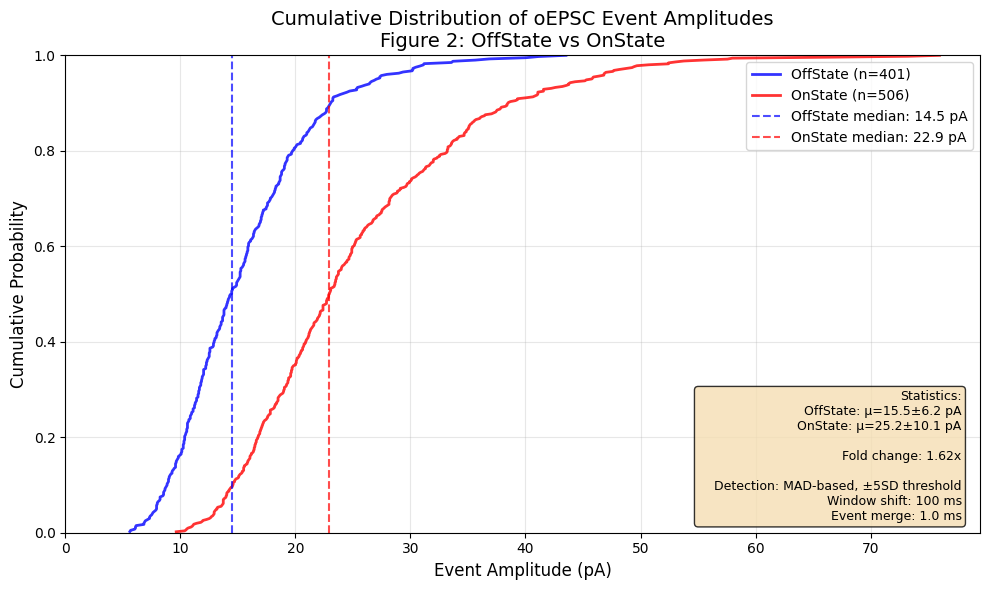

=== CUMULATIVE DISTRIBUTION ANALYSIS ===
OffState events: 401
  Mean: 15.54 ± 6.15 pA
  Median: 14.47 pA
  25th percentile: 10.99 pA
  75th percentile: 18.80 pA

OnState events: 506
  Mean: 25.25 ± 10.13 pA
  Median: 22.95 pA
  25th percentile: 17.82 pA
  75th percentile: 30.67 pA

Comparison:
  Mean fold change (OnState/OffState): 1.625
  Median fold change: 1.586

Kolmogorov-Smirnov test:
  KS statistic: 0.4733
  p-value: 6.97e-46
  Significantly different: Yes


In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Create cumulative distribution plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get data for both states
offstate_amplitudes = np.array(event_amplitudes_by_state["OffState"]["all_amplitudes"])
onstate_amplitudes = np.array(event_amplitudes_by_state["OnState"]["all_amplitudes"])

# Check if we have data
if len(offstate_amplitudes) > 0 and len(onstate_amplitudes) > 0:
    
    # Sort the data
    offstate_sorted = np.sort(offstate_amplitudes)
    onstate_sorted = np.sort(onstate_amplitudes)
    
    # Calculate cumulative probabilities
    offstate_cumulative = np.arange(1, len(offstate_sorted) + 1) / len(offstate_sorted)
    onstate_cumulative = np.arange(1, len(onstate_sorted) + 1) / len(onstate_sorted)
    
    # Plot cumulative distributions
    ax.plot(offstate_sorted, offstate_cumulative, 'b-', linewidth=2, 
            label=f'OffState (n={len(offstate_amplitudes)})', alpha=0.8)
    ax.plot(onstate_sorted, onstate_cumulative, 'r-', linewidth=2, 
            label=f'OnState (n={len(onstate_amplitudes)})', alpha=0.8)
    
    # Add median lines
    offstate_median = np.median(offstate_amplitudes)
    onstate_median = np.median(onstate_amplitudes)
    
    ax.axvline(offstate_median, color='blue', linestyle='--', alpha=0.7, 
               label=f'OffState median: {offstate_median:.1f} pA')
    ax.axvline(onstate_median, color='red', linestyle='--', alpha=0.7, 
               label=f'OnState median: {onstate_median:.1f} pA')
    
    # Formatting
    ax.set_xlabel('Event Amplitude (pA)', fontsize=12)
    ax.set_ylabel('Cumulative Probability', fontsize=12)
    ax.set_title('Cumulative Distribution of oEPSC Event Amplitudes\nFigure 2: OffState vs OnState', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, None)
    ax.set_ylim(0, 1)
    
    # Add statistics text box
    stats_text = f"""Statistics:
    OffState: μ={np.mean(offstate_amplitudes):.1f}±{np.std(offstate_amplitudes):.1f} pA
    OnState: μ={np.mean(onstate_amplitudes):.1f}±{np.std(onstate_amplitudes):.1f} pA
    
    Fold change: {np.mean(onstate_amplitudes)/np.mean(offstate_amplitudes):.2f}x
    
    Detection: MAD-based, ±5SD threshold
    Window shift: {detection_window_shift_ms} ms
    Event merge: {event_merge_distance_ms} ms"""
    
    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("=== CUMULATIVE DISTRIBUTION ANALYSIS ===")
    print(f"OffState events: {len(offstate_amplitudes)}")
    print(f"  Mean: {np.mean(offstate_amplitudes):.2f} ± {np.std(offstate_amplitudes):.2f} pA")
    print(f"  Median: {offstate_median:.2f} pA")
    print(f"  25th percentile: {np.percentile(offstate_amplitudes, 25):.2f} pA")
    print(f"  75th percentile: {np.percentile(offstate_amplitudes, 75):.2f} pA")
    
    print(f"\nOnState events: {len(onstate_amplitudes)}")
    print(f"  Mean: {np.mean(onstate_amplitudes):.2f} ± {np.std(onstate_amplitudes):.2f} pA")
    print(f"  Median: {onstate_median:.2f} pA")
    print(f"  25th percentile: {np.percentile(onstate_amplitudes, 25):.2f} pA")
    print(f"  75th percentile: {np.percentile(onstate_amplitudes, 75):.2f} pA")
    
    print(f"\nComparison:")
    print(f"  Mean fold change (OnState/OffState): {np.mean(onstate_amplitudes)/np.mean(offstate_amplitudes):.3f}")
    print(f"  Median fold change: {onstate_median/offstate_median:.3f}")
    
    # Kolmogorov-Smirnov test (if scipy available)
    try:
        from scipy import stats
        ks_stat, ks_p = stats.ks_2samp(offstate_amplitudes, onstate_amplitudes)
        print(f"\nKolmogorov-Smirnov test:")
        print(f"  KS statistic: {ks_stat:.4f}")
        print(f"  p-value: {ks_p:.2e}")
        print(f"  Significantly different: {'Yes' if ks_p < 0.05 else 'No'}")
    except ImportError:
        print("\nNote: scipy not available for statistical testing")

else:
    print("No data available for plotting")
    if len(offstate_amplitudes) == 0:
        print("  OffState: No events detected")
    if len(onstate_amplitudes) == 0:
        print("  OnState: No events detected")

/tmp/ipykernel_216123/3909179503.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax1.boxplot(box_data, labels=box_labels, patch_artist=True,


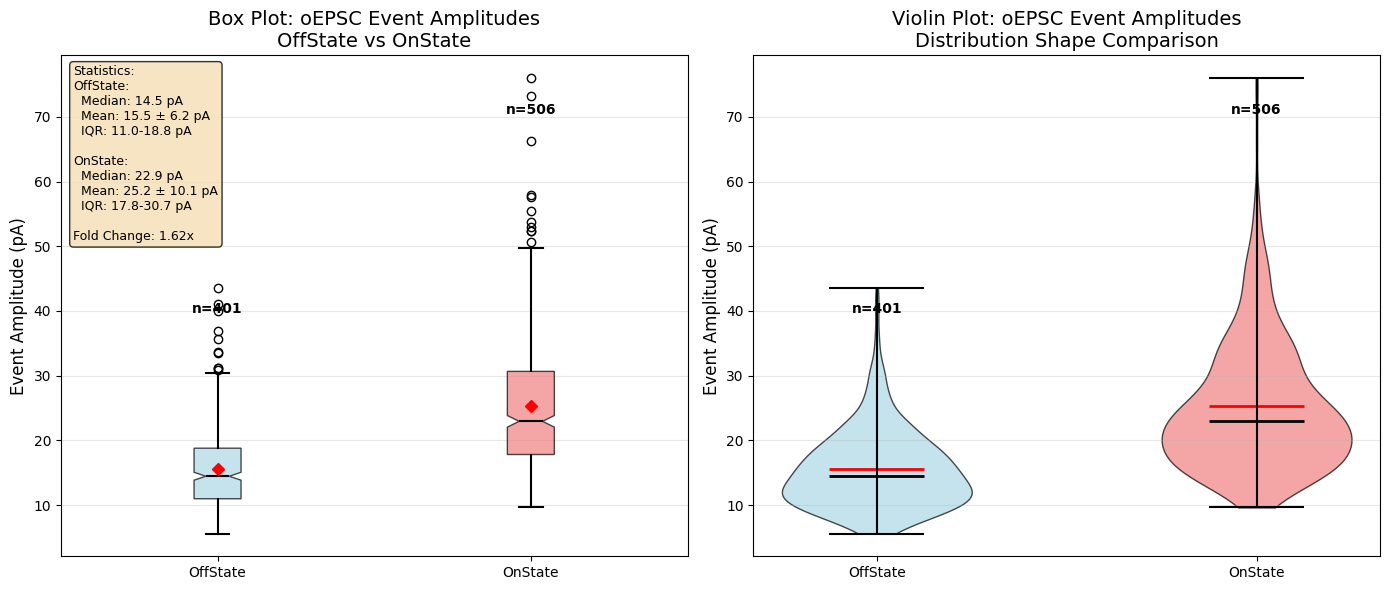

=== BOX PLOT STATISTICAL ANALYSIS ===

OffState (n=401):
  Median: 14.47 pA
  Mean: 15.54 ± 6.15 pA
  IQR: 10.99 - 18.80 pA
  Range: 5.62 - 43.52 pA

OnState (n=506):
  Median: 22.95 pA
  Mean: 25.25 ± 10.13 pA
  IQR: 17.82 - 30.67 pA
  Range: 9.64 - 75.99 pA

Comparison:
  Median fold change: 1.586
  Mean fold change: 1.625
  Difference in medians: 8.48 pA
  Difference in means: 9.71 pA

Mann-Whitney U test (non-parametric):
  U statistic: 37250.50
  p-value: 2.44e-60
  Significantly different: Yes

Welch's t-test (unequal variances):
  t statistic: -17.7925
  p-value: 1.84e-60
  Significantly different: Yes

Effect size (Cohen's d): 1.129
  Effect size interpretation: large


In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Create box plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Get data for both states
offstate_amplitudes = np.array(event_amplitudes_by_state["OffState"]["all_amplitudes"])
onstate_amplitudes = np.array(event_amplitudes_by_state["OnState"]["all_amplitudes"])

if len(offstate_amplitudes) > 0 and len(onstate_amplitudes) > 0:
    
    # Box plot comparison
    box_data = [offstate_amplitudes, onstate_amplitudes]
    box_labels = ['OffState', 'OnState']
    
    # Create box plot
    box_plot = ax1.boxplot(box_data, labels=box_labels, patch_artist=True, 
                          notch=True, showmeans=True)
    
    # Customize box plot colors
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Customize other elements
    for element in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box_plot[element], color='black', linewidth=1.5)
    
    # Customize means
    plt.setp(box_plot['means'], marker='D', markerfacecolor='red', 
             markeredgecolor='red', markersize=6)
    
    ax1.set_ylabel('Event Amplitude (pA)', fontsize=12)
    ax1.set_title('Box Plot: oEPSC Event Amplitudes\nOffState vs OnState', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add sample sizes as text
    ax1.text(1, np.max(offstate_amplitudes) * 0.95, f'n={len(offstate_amplitudes)}', 
             ha='center', va='top', fontweight='bold')
    ax1.text(2, np.max(onstate_amplitudes) * 0.95, f'n={len(onstate_amplitudes)}', 
             ha='center', va='top', fontweight='bold')
    
    # Add statistical annotations
    off_median = np.median(offstate_amplitudes)
    on_median = np.median(onstate_amplitudes)
    off_mean = np.mean(offstate_amplitudes)
    on_mean = np.mean(onstate_amplitudes)
    
    stats_text = f"""Statistics:
OffState:
  Median: {off_median:.1f} pA
  Mean: {off_mean:.1f} ± {np.std(offstate_amplitudes):.1f} pA
  IQR: {np.percentile(offstate_amplitudes, 25):.1f}-{np.percentile(offstate_amplitudes, 75):.1f} pA

OnState:
  Median: {on_median:.1f} pA  
  Mean: {on_mean:.1f} ± {np.std(onstate_amplitudes):.1f} pA
  IQR: {np.percentile(onstate_amplitudes, 25):.1f}-{np.percentile(onstate_amplitudes, 75):.1f} pA

Fold Change: {on_mean/off_mean:.2f}x"""
    
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9,
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Violin plot as alternative visualization
    violin_parts = ax2.violinplot([offstate_amplitudes, onstate_amplitudes], 
                                 positions=[1, 2], showmeans=True, showmedians=True)
    
    # Customize violin plot
    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
    
    # Customize other violin elements
    violin_parts['cmeans'].set_color('red')
    violin_parts['cmeans'].set_linewidth(2)
    violin_parts['cmedians'].set_color('black')
    violin_parts['cmedians'].set_linewidth(2)
    violin_parts['cbars'].set_color('black')
    violin_parts['cmins'].set_color('black')
    violin_parts['cmaxes'].set_color('black')
    
    ax2.set_xticks([1, 2])
    ax2.set_xticklabels(['OffState', 'OnState'])
    ax2.set_ylabel('Event Amplitude (pA)', fontsize=12)
    ax2.set_title('Violin Plot: oEPSC Event Amplitudes\nDistribution Shape Comparison', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add sample sizes for violin plot
    ax2.text(1, np.max(offstate_amplitudes) * 0.95, f'n={len(offstate_amplitudes)}', 
             ha='center', va='top', fontweight='bold')
    ax2.text(2, np.max(onstate_amplitudes) * 0.95, f'n={len(onstate_amplitudes)}', 
             ha='center', va='top', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical testing
    print("=== BOX PLOT STATISTICAL ANALYSIS ===")
    print(f"\nOffState (n={len(offstate_amplitudes)}):")
    print(f"  Median: {off_median:.2f} pA")
    print(f"  Mean: {off_mean:.2f} ± {np.std(offstate_amplitudes):.2f} pA")
    print(f"  IQR: {np.percentile(offstate_amplitudes, 25):.2f} - {np.percentile(offstate_amplitudes, 75):.2f} pA")
    print(f"  Range: {np.min(offstate_amplitudes):.2f} - {np.max(offstate_amplitudes):.2f} pA")
    
    print(f"\nOnState (n={len(onstate_amplitudes)}):")
    print(f"  Median: {on_median:.2f} pA")
    print(f"  Mean: {on_mean:.2f} ± {np.std(onstate_amplitudes):.2f} pA") 
    print(f"  IQR: {np.percentile(onstate_amplitudes, 25):.2f} - {np.percentile(onstate_amplitudes, 75):.2f} pA")
    print(f"  Range: {np.min(onstate_amplitudes):.2f} - {np.max(onstate_amplitudes):.2f} pA")
    
    print(f"\nComparison:")
    print(f"  Median fold change: {on_median/off_median:.3f}")
    print(f"  Mean fold change: {on_mean/off_mean:.3f}")
    print(f"  Difference in medians: {on_median - off_median:.2f} pA")
    print(f"  Difference in means: {on_mean - off_mean:.2f} pA")
    
    # Statistical tests
    try:
        from scipy import stats
        
        # Mann-Whitney U test (non-parametric)
        u_stat, u_p = stats.mannwhitneyu(offstate_amplitudes, onstate_amplitudes, 
                                        alternative='two-sided')
        print(f"\nMann-Whitney U test (non-parametric):")
        print(f"  U statistic: {u_stat:.2f}")
        print(f"  p-value: {u_p:.2e}")
        print(f"  Significantly different: {'Yes' if u_p < 0.05 else 'No'}")
        
        # Welch's t-test (unequal variances)
        t_stat, t_p = stats.ttest_ind(offstate_amplitudes, onstate_amplitudes, 
                                    equal_var=False)
        print(f"\nWelch's t-test (unequal variances):")
        print(f"  t statistic: {t_stat:.4f}")
        print(f"  p-value: {t_p:.2e}")
        print(f"  Significantly different: {'Yes' if t_p < 0.05 else 'No'}")
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(offstate_amplitudes)-1)*np.var(offstate_amplitudes) + 
                            (len(onstate_amplitudes)-1)*np.var(onstate_amplitudes)) / 
                           (len(offstate_amplitudes) + len(onstate_amplitudes) - 2))
        cohens_d = (on_mean - off_mean) / pooled_std
        print(f"\nEffect size (Cohen's d): {cohens_d:.3f}")
        
        if abs(cohens_d) < 0.2:
            effect_size = "negligible"
        elif abs(cohens_d) < 0.5:
            effect_size = "small"
        elif abs(cohens_d) < 0.8:
            effect_size = "medium"
        else:
            effect_size = "large"
        print(f"  Effect size interpretation: {effect_size}")
        
    except ImportError:
        print("\nNote: scipy not available for statistical testing")

else:
    print("No data available for box plot")
    if len(offstate_amplitudes) == 0:
        print("  OffState: No events detected")
    if len(onstate_amplitudes) == 0:
        print("  OnState: No events detected")

## All events

VoltageClampSeriesSweep001 - MAD-STD: 2.71 pA, Median: -368.77 pA, Events: 0
VoltageClampSeriesSweep002 - MAD-STD: 2.94 pA, Median: -357.12 pA, Events: 0
VoltageClampSeriesSweep003 - MAD-STD: 1.81 pA, Median: -349.12 pA
  Negative event amplitudes: ['9.6', '10.7'] pA
VoltageClampSeriesSweep004 - MAD-STD: 2.81 pA, Median: -368.90 pA
  Negative event amplitudes: ['15.0', '16.4', '17.8', '19.0', '19.8', '20.7', '21.7', '22.7', '22.9', '23.4', '24.2', '24.8', '25.6', '26.2', '27.1', '28.2', '29.2', '29.8', '30.1', '30.2', '30.0', '29.8', '29.5', '29.2', '29.7', '30.0', '30.5', '31.1', '31.6', '32.1', '32.3', '32.7', '32.9', '33.1', '33.2', '33.2', '33.3', '33.4', '33.6', '33.7', '33.8', '33.4', '33.7', '33.9', '34.3', '34.7', '34.9', '34.8', '35.0', '35.4', '35.7', '36.3', '36.6', '36.1', '36.3', '36.9', '36.4', '35.7', '35.3', '35.6', '35.4', '34.9', '34.7', '35.3', '35.6', '34.6', '34.2', '34.0', '33.1', '32.4', '31.8', '32.0', '32.4', '32.4', '31.5', '31.0', '31.2', '31.2', '31.6', '31.

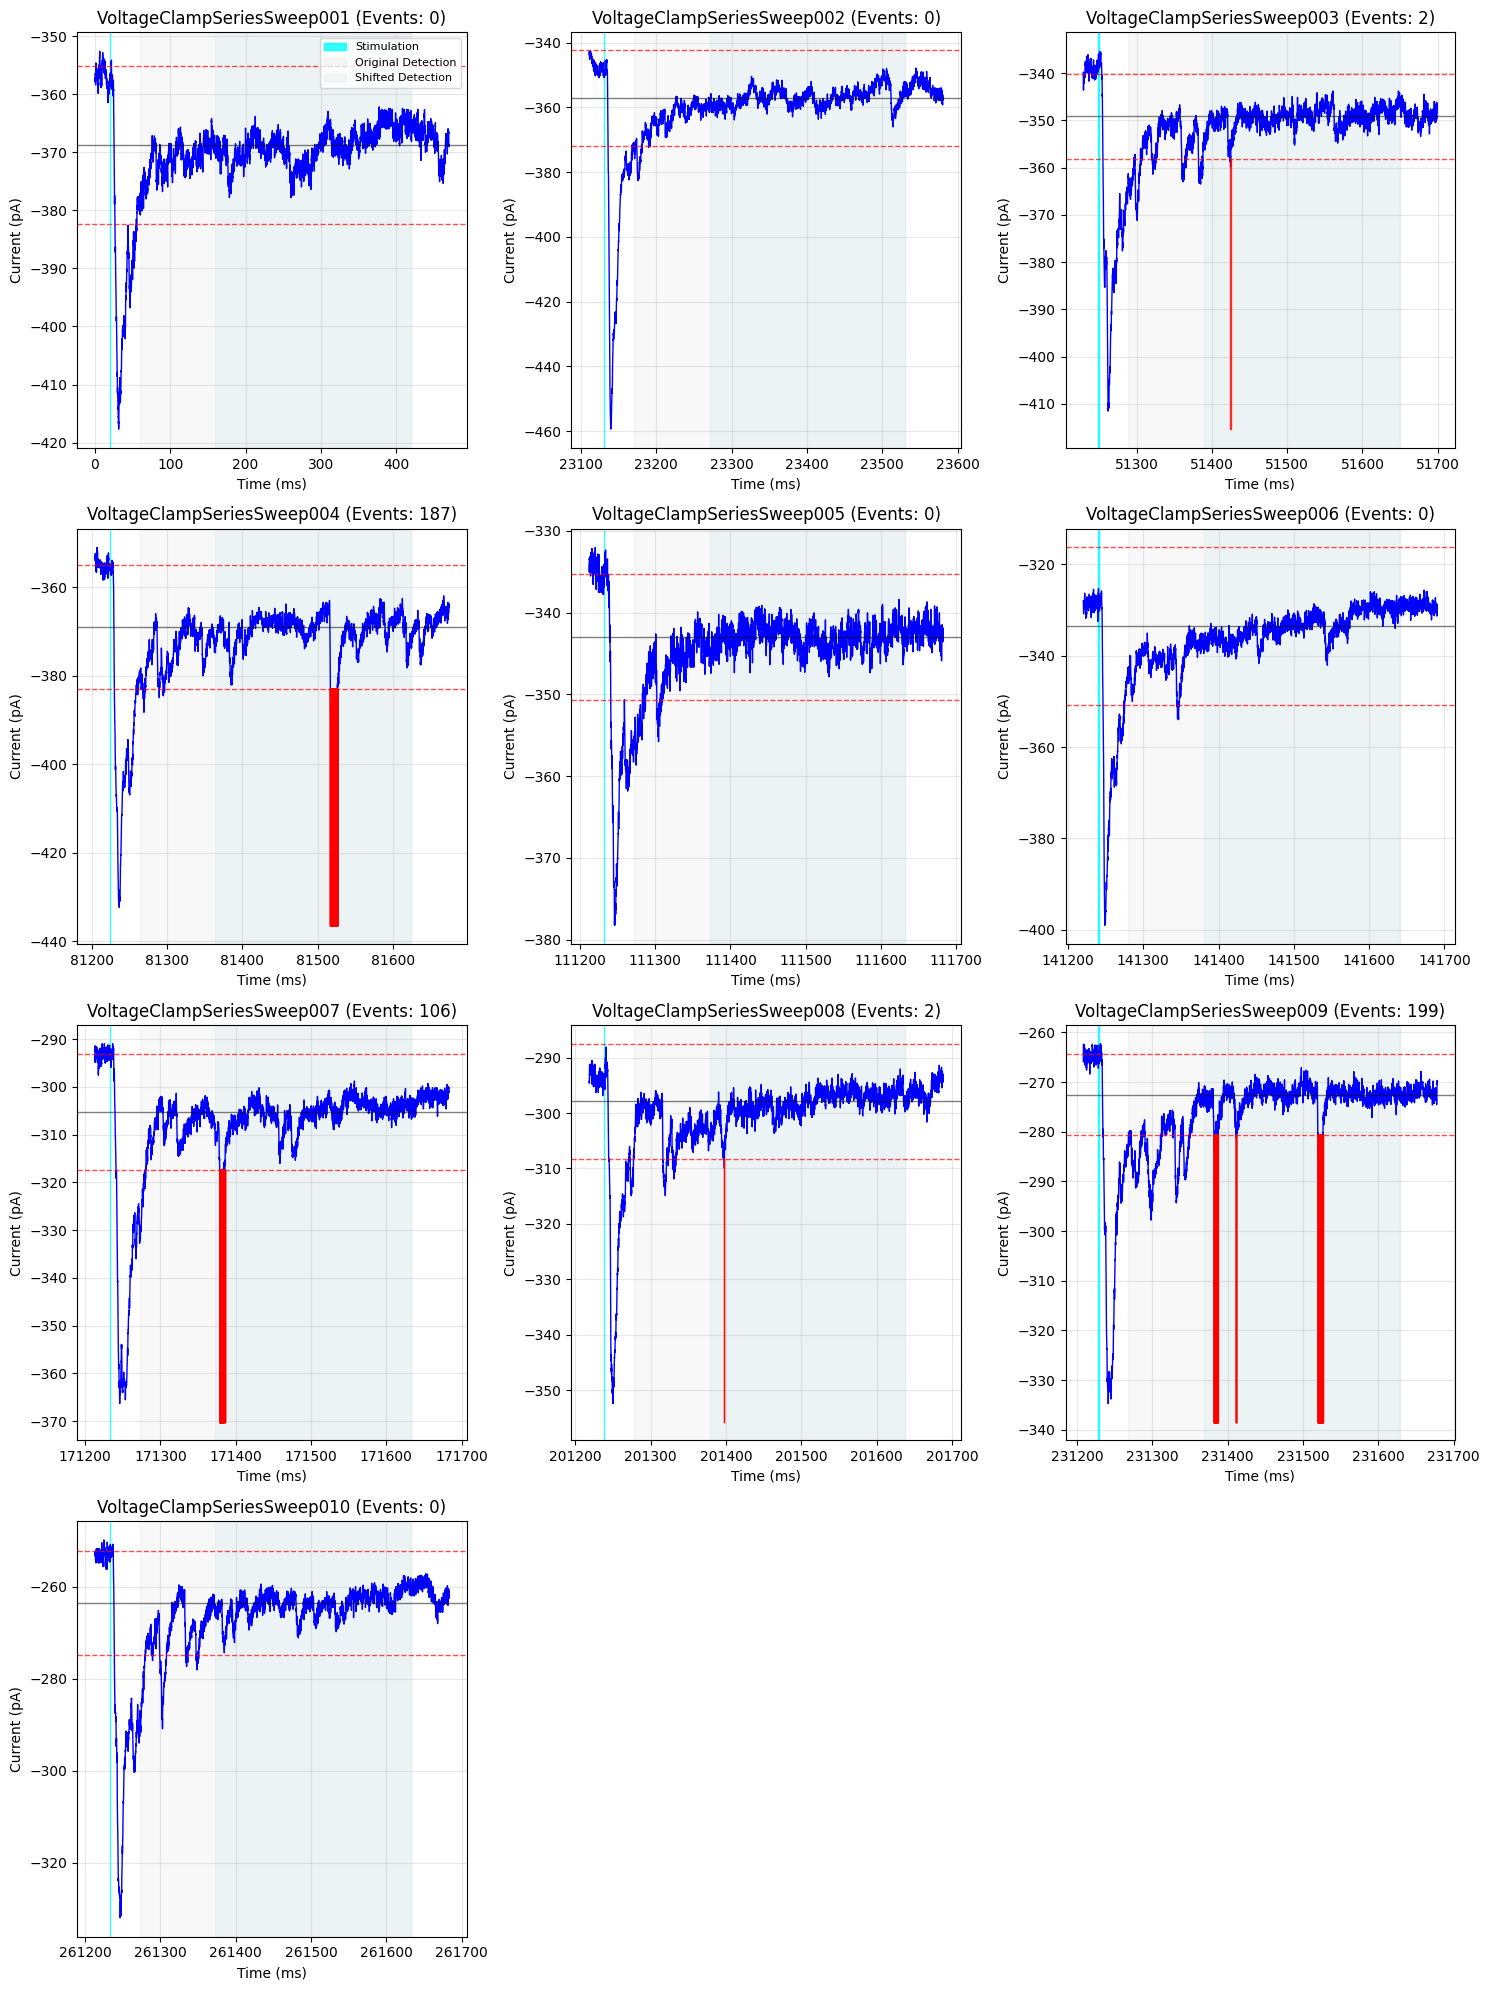


=== EVENT AMPLITUDE SUMMARY ===
Total events detected: 496
Positive events: 0
Negative events: 496

All event amplitudes statistics:
  Mean: 17.27 pA
  Median: 14.65 pA
  Std: 8.23 pA
  Min: 8.18 pA
  Max: 36.87 pA

Negative event amplitudes: 496 events
  Mean: 17.27 pA
  Range: 8.2 to 36.9 pA

Detection window shifted by 100 ms from original start


In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Control parameters
detection_window_shift_ms = 100  # Shift detection window start by this many ms after original start

# Get all acquisition keys
acquisition_keys = list(nwbfile.acquisition.keys())
num_sweeps = len(acquisition_keys)

# Initialize lists to collect event amplitudes
all_positive_amplitudes = []
all_negative_amplitudes = []
all_event_amplitudes = []

# Calculate grid dimensions
cols = 3
rows = (num_sweeps + cols - 1) // cols

# Create subplots grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten() if num_sweeps > 1 else [axes]

# Process each sweep
for i, sweep_key in enumerate(acquisition_keys):
    # Extract trial number from key
    trial_number = int(sweep_key.split('Sweep')[-1])
    
    # Get voltage clamp response
    voltage_clamp_response = nwbfile.acquisition[sweep_key]
    timestamps_in_seconds = voltage_clamp_response.get_timestamps()
    data_in_amperes = voltage_clamp_response.get_data_in_units()
    data_in_pico_amperes = data_in_amperes * 1e12
    
    # Get stimulation and detection info for this trial
    stimulation_info = stimulation_entries_df.iloc[trial_number - 1]
    stimulation_start_ms = stimulation_info["start_time"] * 1000
    stimulation_stop_ms = stimulation_info["stop_time"] * 1000
    
    detection_info = detection_entries_df.iloc[trial_number - 1]
    detection_start_ms_original = detection_info["start_time"] * 1000
    detection_stop_ms = detection_info["stop_time"] * 1000
    
    # Apply shift to detection window start
    detection_start_ms_shifted = detection_start_ms_original + detection_window_shift_ms
    
    # Show data up to 50ms after detection window ends
    timestamps_in_milliseconds = timestamps_in_seconds * 1000
    starting_time = timestamps_in_milliseconds[0]
    end_time = detection_stop_ms + 50
    mask = (timestamps_in_milliseconds >= starting_time) & (timestamps_in_milliseconds <= end_time)
    timestamps_filtered = timestamps_in_milliseconds[mask]
    data_filtered = data_in_pico_amperes[mask]
    
    # Calculate noise statistics within shifted detection window using MAD
    detection_mask = (timestamps_filtered >= detection_start_ms_shifted) & (timestamps_filtered <= detection_stop_ms)
    detection_data = data_filtered[detection_mask]
    detection_timestamps = timestamps_filtered[detection_mask]
    
    # Calculate MAD-based standard deviation
    noise_median = np.median(detection_data)
    mad = np.median(np.abs(detection_data - noise_median))
    # Convert MAD to standard deviation estimate (assuming normal distribution)
    mad_std = mad * 1.4826  # MAD to std conversion factor for normal distribution
    
    event_threshold_positive = noise_median + 5 * mad_std
    event_threshold_negative = noise_median - 5 * mad_std
    
    # Find events and their timestamps
    positive_event_indices = np.where(detection_data > event_threshold_positive)[0]
    negative_event_indices = np.where(detection_data < event_threshold_negative)[0]
    total_events = len(positive_event_indices) + len(negative_event_indices)
    
    # Get event timestamps and amplitudes
    positive_event_times = detection_timestamps[positive_event_indices] if len(positive_event_indices) > 0 else []
    negative_event_times = detection_timestamps[negative_event_indices] if len(negative_event_indices) > 0 else []
    
    # Calculate event amplitudes (deviation from median)
    positive_event_amplitudes = detection_data[positive_event_indices] - noise_median if len(positive_event_indices) > 0 else []
    negative_event_amplitudes = noise_median - detection_data[negative_event_indices] if len(negative_event_indices) > 0 else []
    
    # Collect amplitudes in global lists
    if len(positive_event_amplitudes) > 0:
        all_positive_amplitudes.extend(positive_event_amplitudes)
        all_event_amplitudes.extend(positive_event_amplitudes)
    
    if len(negative_event_amplitudes) > 0:
        all_negative_amplitudes.extend(negative_event_amplitudes)
        all_event_amplitudes.extend(negative_event_amplitudes)
    
    # Plot
    ax = axes[i]
    ax.plot(timestamps_filtered, data_filtered, 'b-', linewidth=1)
    ax.axvspan(stimulation_start_ms, stimulation_stop_ms, color="cyan", alpha=0.8, label="Stimulation")
    ax.axvspan(detection_start_ms_original, detection_stop_ms, color="gray", alpha=0.05, label="Original Detection")
    ax.axvspan(detection_start_ms_shifted, detection_stop_ms, color="lightblue", alpha=0.15, label="Shifted Detection")
    ax.axhline(y=noise_median, color='black', linestyle='-', alpha=0.5, linewidth=1)
    ax.axhline(y=event_threshold_positive, color='red', linestyle='--', alpha=0.7, linewidth=1)
    ax.axhline(y=event_threshold_negative, color='red', linestyle='--', alpha=0.7, linewidth=1)
    
    # Get plot limits for scaling event markers
    y_min, y_max = ax.get_ylim() if len(data_filtered) > 0 else (min(data_filtered), max(data_filtered))
    
    # Add vertical lines for positive events (from top to positive threshold)
    for event_time in positive_event_times:
        ax.plot([event_time, event_time], [event_threshold_positive, y_max], 
                color='red', alpha=0.8, linewidth=1)
    
    # Add vertical lines for negative events (from bottom to negative threshold)
    for event_time in negative_event_times:
        ax.plot([event_time, event_time], [y_min, event_threshold_negative], 
                color='red', alpha=0.8, linewidth=1)
    
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Current (pA)")
    ax.set_title(f"{sweep_key} (Events: {total_events})")
    ax.grid(True, alpha=0.3)
    
    # Add legend only to first subplot
    if i == 0:
        ax.legend(loc='upper right', fontsize=8)
    
    # Print event amplitudes for this sweep
    if len(positive_event_amplitudes) > 0 or len(negative_event_amplitudes) > 0:
        print(f"{sweep_key} - MAD-STD: {mad_std:.2f} pA, Median: {noise_median:.2f} pA")
        if len(positive_event_amplitudes) > 0:
            print(f"  Positive event amplitudes: {[f'{amp:.1f}' for amp in positive_event_amplitudes]} pA")
        if len(negative_event_amplitudes) > 0:
            print(f"  Negative event amplitudes: {[f'{amp:.1f}' for amp in negative_event_amplitudes]} pA")
    else:
        print(f"{sweep_key} - MAD-STD: {mad_std:.2f} pA, Median: {noise_median:.2f} pA, Events: 0")

# Hide empty subplots
for i in range(num_sweeps, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== EVENT AMPLITUDE SUMMARY ===")
print(f"Total events detected: {len(all_event_amplitudes)}")
print(f"Positive events: {len(all_positive_amplitudes)}")
print(f"Negative events: {len(all_negative_amplitudes)}")

if len(all_event_amplitudes) > 0:
    print(f"\nAll event amplitudes statistics:")
    print(f"  Mean: {np.mean(all_event_amplitudes):.2f} pA")
    print(f"  Median: {np.median(all_event_amplitudes):.2f} pA")
    print(f"  Std: {np.std(all_event_amplitudes):.2f} pA")
    print(f"  Min: {np.min(all_event_amplitudes):.2f} pA")
    print(f"  Max: {np.max(all_event_amplitudes):.2f} pA")

if len(all_positive_amplitudes) > 0:
    print(f"\nPositive event amplitudes: {len(all_positive_amplitudes)} events")
    print(f"  Mean: {np.mean(all_positive_amplitudes):.2f} pA")
    print(f"  Range: {np.min(all_positive_amplitudes):.1f} to {np.max(all_positive_amplitudes):.1f} pA")

if len(all_negative_amplitudes) > 0:
    print(f"\nNegative event amplitudes: {len(all_negative_amplitudes)} events")
    print(f"  Mean: {np.mean(all_negative_amplitudes):.2f} pA")
    print(f"  Range: {np.min(all_negative_amplitudes):.1f} to {np.max(all_negative_amplitudes):.1f} pA")

print(f"\nDetection window shifted by {detection_window_shift_ms} ms from original start")